<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/toc-cleanup-p1c3/sequences/P1C3_RealEvolution/P1C3_Sequence2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **1.3.2: Why Sex**
### Objective:
In the last sequence we explored the fundamentals of evolution using a simple 'strike-no-strike' (binary classification) problem 'solved' by the selective expression of (highly abstract) chemosensory receptors. Our primary focus was on the parallels between evolutionary processes and optimization. We hinted at the importance of mutation, population size, and strength of selection in determining whether or not a 'good' solution could even be found by our evolutionary process. In this sequence we are going to go a little deeper in our analysis and look not only at whether or not a 'good' solution can be found at all, but also at how quickly such a solution is found by an evolutionary process, both in terms of number of generations and computational efficiency. We then show how sex (more specifically recombination) radically accelerates this process. We end by introducing some of the arguments for why evolution will select for mechanisms, like sex and recombination, that accelerate adaptation by natural selection (i.e. why we would expect evolution to be self accelerating!)

In this sequence we explore the following questions through simulations and mathematical analyses:

* How do population size, mutation rate, and strength of selection impact the number of generations required for an evolutionary process to discover an 'optimal' solution?

* How and why does recombination increase the speed with which an evolutionary process discovers an 'optimal' solution?

* Why does the rate of adaptation matter from an evolutionary perspective?


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @markdown **Dependencies, Imports and Setup.** You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C3_S2"

Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 1.3.1.1: Strength of Selection and Rate of Adaptation

We will continue to use the 'strike-no-strike' decision problem of the last sequence, but with a specific environment tailored to streamline our simulations, reasoning and analysis. Consider an organism with $n$ chemosensory receptors, each corresponding to $n$ possible food/non-food chemical markers in the environment. The expression of these receptors is determined by $n$ distinct genetic switches, represented as a bit-string $g$ of length $n$ with 1 corresponding to expression and 0 to absence of the corresponding receptor. In this simplified environment the marker for the one food item consists of all 1's. There are $n$ non-food items that closely mimic this food signal, with each non-food item's marker differing from the food-item marker in exactly one marker/receptor slot. With $n$ receptors, this means we have $n$ distinct non-food item markers, each with a distinct location for its solitary zero disrupting an otherwise unbroken set 1's.   

Recall a successful strike at edible food yields a reward, $r$ and conversely, a missed strike has a cost, $c$. Not striking (both true and false negative) yield zero cost or reward. We think of these costs and rewards as a constant increment by $r$ or decrement by $c$ respectively to offspring quality and/or quantity. The organism's decision rule is to strike only if ***all*** of its receptors pick up a marker and refrains from striking if ***any*** of its receptors are left unactivated. (When the organism has no receptors technically all of its non-existent receptors are activated and so it strikes in all situations.)

With this decision rule, in this environment, the organism will always strike at the food-item. Each additional receptor expressed serves to sift out one specific type of non-food item, thereby reducing false positives. The singular 'optimal' genotype in this simple environment consists of all 1's.



## **TODO** Picture: Chemosensory Strike-No-Strike Mechanism (again)

Let $p$ be the probability of encountering a food item and $1-p$ the probability of an encounter with a non-food item. Given $k$ trials, an organism is expected to encounter $p k$ food items for a total expected increment of $p k r$ from food items. It can also expect to encounter $(1-p)k$ non-food items, with each of $n$ distinct non-food item types encountered with equal probability. If a non-food item is encountered and the organism expresses the receptor that filters it out then the organism pays no cost, but if they do not express the filtering receptor particular to that specific non-food item they strike at the non-food item and pay a cost of $c$. Then, the total expected decrement from false strikes is $k (1-p) \frac{c}{n} \sum_{i=1}^{n} (1 - g_i)$. Thus the expression of each receptor, i.e. having allele '1' instead of '0' at any loci, confers a small, independent, additive benefit $ k (1-p) \frac{c}{n}$. The total expected gamete quality/quantity increment is

$$pkr - k (1-p)\frac{c}{n} \sum_{i=1}^n (1-g_i).$$

We can further simplify, setting $p = \frac{1}{2}$ and $c=r= \frac{2n}{k}$, and assuming that $k$ is very large. Even though the gamete increment for any one individual is a random variable dependent on how many food versus non-food items they encounter and which non-food items they encounter relative to the non-food items they effectively filter out, for large enough $k$ this randomness averages out and we will treat the gamete increment of an individual as a deterministic function of their genotype, specifically

$$ z(g) = \sum_{i=1}^n g_i $$

In this sense our scenario is very similar to that analyzed in "Information Theory, Inference, and Learning Algorithms" by David MacKay book and in "Beneficial Mutation-Selection Balance and the Effect of Linkage on Positive Selection" by Desai & Fisher 2007.

Before getting into any analyses let's observe through simulation, how mutation rate, population size, and strength of selection impact two things in this simplified environment:
1. the final average score level achieved by the population and
2. the time it takes, in generations, for the evolutionary process to discover the optimal genotype (if at all) in this simplest of possible fitness landscapes.

While mutation rate and population size are relatively straightforward concepts readily captured with a single variable, strength of selection is a more nebulous concept that requires deeper consideration. To think clearly about strength of selection we first need to be precise about what we mean by fitness.

___
## Bio Box: What is "Fitness" in Evolution
The word fitness is often used loosely to mean anything which influences reproductive success and survival as a result of being 'well fit' to the environment. This is fine, but if we wish to quantify and be more precise about evolutionary dynamics, and in particular strength of selection we need to refine our thinking around the term fitness first.

In a strict sense fitness is defined as the growth (or decline) rate of the proportion of an allele, type, lineage, or really anything the can be unambiguously categorized and then counted or measured, in a population from one census time to the next. So if $p_i(t)$ is the proportion of type $i$ in the population at time $t$ and $p_i(t+1)$ the proportion at time $t+1$ then the fitness of type $i$ in that population with that census interval is $w_i(t) = \frac{p_i(t+1)}{p_i(t)}$.

This definition of fitness hinges on the idea of a population, discrete census times, and unambiguous categorization and counting of types. There is an equivalent continuous time version of this definition based on differential equations of continuously evolving proportions instead of ratios between census time counts.

When fitness is defined in terms of population proportions like this, average fitness across the population is always exactly 1. This means fitness is always about **relative** advantage, i.e. how much more quickly does one gene spread versus another or how much more quickly does one lineage expand compared to another. In most evolutionary models the function often referred to as the 'fitness' function does not directly give fitness in the strict sense of growth rate (as defined above), but rather some score upon which selection and reproduction is based. This is confusing. To help avoid this confusion, we will call such functions 'fitness score' functions to differentiate them from fitness in the strict sense of reproductive rate. In our model above $z(g)$ is such a 'fitness score' function. It gives a score to each genotype, but how this score translates into an actual rate of reproduction will depend on the specific details of the evolutionary model. Because fitness in the strict sense is **relative** growth, the fitness of any one type will **always** depend on the relative frequencies and 'fitness scores' of the various other types in the population. The details of this dependency emerge from the specifics of the evolutionary model, in particular exactly how selective reproduction and survival is determined by the 'fitness score'.
___


## Coding Exercise: Different Selection Types

In this coding exercise we implement three different kinds of selection mechanism and see how they impact an evolutionary simulation while holding mutation rate and population size constant. This will help us to develop a sense of the impact of 'selection strength' and how it might be operationalized both in our simulations and models, but also out in the real world both by breeders (artificial selection) and in the wild (natural selection).

Each individual in the population has a genotype $g$, and a resulting score $z(g) = \sum_{i=1}^n g_i$, i.e. the number of 'good bits'. But, how should these scores translate into probabilities of reproduction, or reproductive rates? There are many reasonable models, that correspond (roughly) to different realistic situations. Here are a few.


1. **Proportional Selection:** Each individual's probability of being a parent is strictly proportional to their score. This corresponds roughly to broadcast style egg laying and fertilization as utilized by many sea creatures and plants. If we interpret $r$ and $c$ in terms of gametes produced that then 'compete' in the sense of being lucky and landing on a limited number of viable sites, this is a good model. This also aligns with the idea of each gene giving a small additive increase to reproductive rate. Note however that as the average 'fitness score' baseline of the population increases, the relative impact on reproductive rate from any one gene will decrease.
2. **Truncation Selection (Deterministic Uniform):** Each individuals' probability of being a parent is exactly 1 if they have a score above a certain threshold quantile, and exactly 0 if they are below that threshold quantile. The number of offspring produced by each parent is the same, so e.g. if a population has fixed size, and a cut-off quantile or $0.5$, each parent would produce exactly 2 offspring. If $z(g)$ were interpreted as offspring quality instead of quantity, and there was strict 'survival of the fittest' this would be a good model. Similarly, if $z(g)$ corresponded to something a breeding farmer was trying to maximize like milk or egg production, or weight gain efficiency per feedstock inputs over some time interval, then truncation selection would also be a good model.
3. **Softmax Proportional Selection:** Each individual's probability of being a parent is proportional to a (scaled) exponential of their score. For low temperature scaling, this becomes somewhat like truncation selection, with only the most fit individuals having any real chance of reproduction, i.e. very strong selection. With high temperature scaling selection is very weak. Regardless of the temperature, with probability of reproduction proportional to the exponential of score, each gene gives a constant multiplicative increase to reproductive rate. Unlike the proportional selection case, the relative impact on reproductive rate from any one gene remains constant regardless of the current baseline 'fitness score'.

Various combinations of these three basic types (and many other forms besides) are possible, but focussing on these three is sufficient for our illustrative purposes. Now let's implement them.

In [2]:
################################################################################
# TODO for students: Complete the lines with ... to implement different forms
# of selection within this highly simplified evolutionary simulation. This is
# a long function, you're going to have to dig a bit to find the relevant part.
raise NotImplementedError("Exercise: implement different forms of selection")
################################################################################


def selection_variation_type_simulation(
    pop_size=1000, n_gen=100, n_rcpt=100,
    mutation_rate=0.005, has_mutation=True,
    has_distinct_types=False,
    has_recombination=False, has_assortative_pairing=True,
    selection_type='proportional', #softmax, deterministic truncation, proportional truncation
    softmax_temp=1, truncation_threshold=0.5,
    seed=None, init_pop='simple'): # mutation_eq, recomb_eq
  """
  Simulates the evolutionary process in a population of genotypes playing the
  Strike-No-Strike game using different types of selection.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  # Initialize population
  if init_pop == 'simple':
    population = rng.integers(0, 2, size=(pop_size, n_rcpt),
                              dtype=np.bool_)
  elif init_pop == 'adapted':
    population = np.ones((pop_size, n_rcpt), dtype=np.bool_)
  elif init_pop != 'simple':
    # for agreement with theoretical models we initialize population so that
    # variance starts at 'dynamic equilibrium' level
    if init_pop == 'mutation_eq':
      # Calculate n' and b
      n_prime = int(2 * mutation_rate * n_rcpt * (np.pi - 2))
      b = int(n_rcpt * (-2 * np.pi * mutation_rate + 4 * mutation_rate + 1) / 2)
    elif init_pop == 'recomb_eq':
      n_prime = int(n_rcpt*(np.pi - 2) / (2 + np.pi))
      b = int(2 * n_rcpt / (2 + np.pi))
    # Generate shifted binomial distribution
    num_ones = rng.binomial(n_prime, 0.5, size=pop_size) + b
    population = np.zeros((pop_size, n_rcpt), dtype=np.bool_)
    # Assign '1's randomly for each population member
    for i in range(pop_size):
      one_positions = rng.choice(n_rcpt, num_ones[i], replace=False)
      population[i, one_positions] = True

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers
    if not (np.isclose(num_parents, np.round(num_parents)) and np.isclose(offspring_per_parent, np.round(offspring_per_parent))):
      print(truncation_threshold)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, both pop_size * (1-truncation_threshold) and 1/(1-truncation_threshold) must result in integers.")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotype scores over generations.
  mean_hist = np.zeros(n_gen)
  mean_after_sel_hist = np.zeros(n_gen)
  var_hist = np.zeros(n_gen)
  skew_hist = np.zeros(n_gen)
  lower_quartile_hist = np.zeros(n_gen)
  upper_quartile_hist = np.zeros(n_gen)

  # label individuals as recombinors and/or mutators or not
  if has_recombination:
    if has_distinct_types:
      recombination_labels = np.zeros(pop_size, dtype=bool)
      recombination_labels[:pop_size // 2] = True
      rng.shuffle(recombination_labels)
    else:
      recombination_labels = np.ones(pop_size, dtype=bool)
  else:
    recombination_labels = np.zeros(pop_size, dtype=bool)

  if has_mutation:
    if has_distinct_types:
      mutation_labels = np.zeros(pop_size, dtype=bool)
      mutation_labels[:pop_size // 2] = True
      rng.shuffle(mutation_labels)
    else:
      mutation_labels = np.ones(pop_size, dtype=bool)
  else:
    mutation_labels = np.zeros(pop_size, dtype=bool)
  # Track statistics of distinct types if we have them
  if has_distinct_types:
    mutator_non_recombinator = mutation_labels & ~recombination_labels
    recombinator_non_mutator = ~mutation_labels & recombination_labels
    neither = ~mutation_labels & ~recombination_labels
    both = mutation_labels & recombination_labels
    present_types = {
            'mutator_non_recombinator': np.sum(mutator_non_recombinator) > 0,
            'recombinator_non_mutator': np.sum(recombinator_non_mutator) > 0,
            'neither': np.sum(neither) > 0,
            'both': np.sum(both) > 0}
    type_count_hist = {key: np.zeros(n_gen) for key, value in present_types.items() if value}
    type_mean_fitness_hist = {key: np.zeros(n_gen) for key, value in present_types.items() if value}

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    scores = np.sum(np.array(population, dtype=float), axis=1)

    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0
    # Track statistics genotype scores over generations.
    mean_hist[generation] = mean_
    var_hist[generation] = var_
    skew_hist[generation] = skew_
    lower_quartile_hist[generation] = np.percentile(scores, 25)
    upper_quartile_hist[generation] = np.percentile(scores, 75)

    ###########################################################################
    # Student exercises in this code block on selection types
    ###########################################################################
    # Selective Reproduction
    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = ...
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = ...
      prob_scores = ...
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      # Deterministic truncation selection
      threshold_score = np.quantile(...)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= ...)[0]
      # If there are more eligible individuals than needed, select randomly
      if len(eligible_indices) > num_parents:
        selected_indices = rng.choice(eligible_indices, size=num_parents, replace=False)
      else:
        selected_indices = eligible_indices
      # Create the new population
      new_population = []
      new_mutation_labels = []
      new_recombination_labels = []
      for idx in selected_indices:
        new_population.extend([population[idx]] * offspring_per_parent)
        if has_mutation:
          new_mutation_labels.extend([mutation_labels[idx]] * offspring_per_parent)
        if has_recombination:
          new_recombination_labels.extend([recombination_labels[idx]] * offspring_per_parent)
      population = np.array(new_population)
      if has_mutation:
        mutation_labels = np.array(new_mutation_labels, dtype=bool)
      if has_recombination:
        recombination_labels = np.array(new_recombination_labels, dtype=bool)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")
    if selection_type != 'deterministic truncation':
      selected_indices = rng.choice(pop_size, size=pop_size, p=prob_scores, replace=True)
      population = population[selected_indices]
      if has_distinct_types:
        if has_mutation:
          mutation_labels = mutation_labels[selected_indices]
        if has_recombination:
          recombination_labels = recombination_labels[selected_indices]
    ###########################################################################
    # No more student exercises outside this code block on selection types
    ###########################################################################

    post_selection_score = np.sum(np.array(population, dtype=float), axis=1)
    mean_after_sel_hist[generation] = np.mean(post_selection_score)

    # track counts and mean fitness score of different types
    if has_distinct_types:
      # Identify each type based on mutation and recombination labels
      mutator_non_recombinator = mutation_labels & ~recombination_labels
      recombinator_non_mutator = ~mutation_labels & recombination_labels
      neither = ~mutation_labels & ~recombination_labels
      both = mutation_labels & recombination_labels
      for type_label, present in present_types.items():
        if present:
          if type_label == 'mutator_non_recombinator':
            type_indices = mutator_non_recombinator
          elif type_label == 'recombinator_non_mutator':
            type_indices = recombinator_non_mutator
          elif type_label == 'neither':
            type_indices = neither
          elif type_label == 'both':
            type_indices = both

          # Count individuals of this type
          type_count_hist[type_label][generation] = np.sum(type_indices)
          # Calculate mean fitness for this type
          if np.any(type_indices):  # To handle division by zero
            type_mean_fitness = np.mean(post_selection_score[type_indices])
          else:
            type_mean_fitness = 0
          type_mean_fitness_hist[type_label][generation] = type_mean_fitness

    # mutation
    if has_mutation:
      if has_distinct_types:
        # Apply mutation only to mutators, identified by mutation_labels
        mutators = population[mutation_labels]
        mutation_mask = rng.random(mutators.shape) < mutation_rate
        mutators ^= mutation_mask
        population[mutation_labels] = mutators
      else:
        # Apply mutation to the entire population
        mutation_mask = rng.random(population.shape) < mutation_rate
        population ^= mutation_mask

    # recombination
    if has_recombination:
      if has_distinct_types:
        recombiners = population[recombination_labels]
        non_recombiners = population[~recombination_labels]
        #make sure even number of recombiners
        if len(recombiners) % 2 != 0:
          # Move the last recombiner to the non-recombiners
          non_recombiners = np.append(non_recombiners, [recombiners[-1]], axis=0)
          recombiners = recombiners[:-1]
        num_recombiners = len(recombiners)
        recombiner_mutation_labels = mutation_labels[recombination_labels]
        non_recombiner_mutation_labels = mutation_labels[~recombination_labels]
      else:
        recombiners = population

      # Shuffle the indices of the recombing population
      shuffled_indices = rng.permutation(num_recombiners)
      shuffled_recombiners = recombiners[shuffled_indices]
      #mating can be assortative or totally random
      if has_assortative_pairing:
        shuffled_scores = np.sum(np.array(shuffled_recombiners, dtype=float), axis=1)
        # Sort the shuffled population based on scores for assortative mating
        sorted_indices = np.argsort(shuffled_scores)
        sorted_recombiners = shuffled_recombiners[sorted_indices]
        # Reshape sorted population to group similar parents into pairs
        parent_pairs = sorted_recombiners.reshape(num_recombiners // 2, 2, n_rcpt)
      else:
        # Reshape shuffled population to group similar parents into pairs
        parent_pairs = shuffled_recombiners.reshape(num_recombiners // 2, 2, n_rcpt)
      mask1 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt)).astype(np.bool_)
      mask2 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt)).astype(np.bool_)
      children = np.empty_like(parent_pairs)
      children[:, 0, :] = np.where(mask1, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      children[:, 1, :] = np.where(mask2, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      recombined_population = children.reshape(num_recombiners, n_rcpt)
      if has_distinct_types:
        population = np.concatenate([recombined_population, non_recombiners])
        recombiner_labels_bool = np.full(len(recombiners), True, dtype=bool)
        non_recombiner_labels_bool = np.full(len(non_recombiners), False, dtype=bool)
        recombination_labels = np.concatenate([recombiner_labels_bool, non_recombiner_labels_bool])
        if has_mutation:
          mutation_labels = np.concatenate([recombiner_mutation_labels,
                                            non_recombiner_mutation_labels])
      else:
        population = recombined_population



  results = {
    'mean_hist': mean_hist,
    'mean_after_sel_hist': mean_after_sel_hist,
    'var_hist': var_hist,
    'skew_hist': skew_hist,
    'upper_quartile_hist': upper_quartile_hist,
    'lower_quartile_hist': lower_quartile_hist}
  if has_distinct_types:
    results['type_count_hist'] = type_count_hist
    results['type_mean_fitness_hist'] = type_mean_fitness_hist
  return results


def plot_selection_results(ax, selection_type='deterministic_truncation',
                           n_gen=200, color='red', label='', seed=123,
                           softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=0.005, pop_size=1000,
                           has_distinct_types=False, has_mutation=False,
                           has_recombination=False, has_assortative_pairing=False,
                           plot_IQR=True, init_pop='simple'):
    r = selection_variation_type_simulation(
        selection_type=selection_type,
        n_gen=n_gen,
        seed=seed,
        softmax_temp=softmax_temp,
        truncation_threshold=truncation_threshold,
        mutation_rate=mutation_rate,
        has_distinct_types=has_distinct_types,
        has_mutation=has_mutation,
        has_recombination=has_recombination,
        has_assortative_pairing=has_assortative_pairing,
        pop_size=pop_size,
        init_pop=init_pop)
    generations = np.arange(n_gen)
    if plot_IQR:
      ax.fill_between(generations, r['lower_quartile_hist'],
                      r['upper_quartile_hist'],
                      color=color, alpha=0.2)
    ax.plot(generations, r['mean_hist'], color=color, label=label)

# Parameters
common_params = {
    'n_gen': 200,
    'pop_size': 1000,
    'seed': 123,
    'mutation_rate': 0.005,
    'has_mutation': True,
    'has_recombination': False,
    'has_assortative_pairing': True,
    'has_distinct_types': False
}

softmax_params = {
    'selection_type': 'softmax',
    'color': 'green',
    'label': 'Softmax',
    'softmax_temp': 1,
}

truncation_params = {
    'selection_type': 'deterministic truncation',
    'color': 'red',
    'label': 'Truncation - 50%',
    'truncation_threshold': 0.5,
}

proportional_params = {
    'selection_type': 'proportional',
    'color': 'blue',
    'label': 'Proportional',
    }


fig, ax = plt.subplots(figsize=(10, 4))

ig, ax = plt.subplots(figsize=(10, 4))

plot_selection_results(ax, **softmax_params, **common_params)
plot_selection_results(ax, **truncation_params, **common_params)
plot_selection_results(ax, **proportional_params, **common_params)

ax.set_xlabel('Generation')
ax.set_ylabel('Population Score\nMean+IQR')
ax.set_title('Comparison of Selection Types over Generations')
ax.legend()

remove_ip_clutter(fig)
plt.show()

NotImplementedError: Exercise: implement different forms of selection

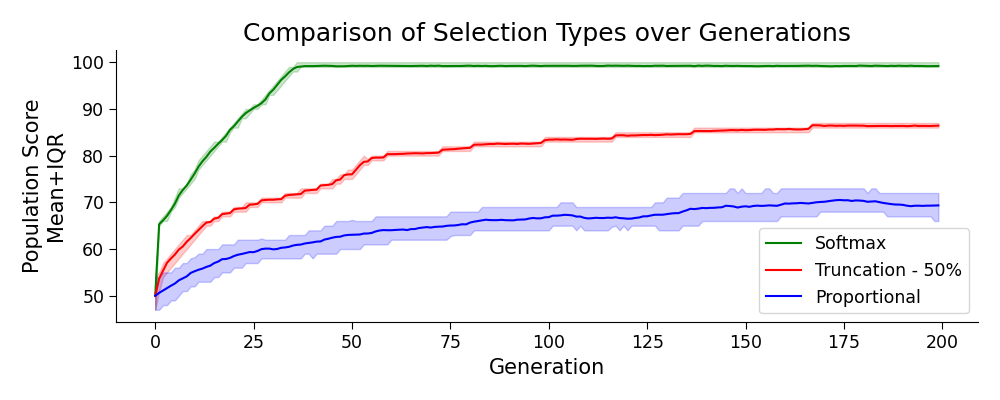

In [3]:
# to_remove solution

def selection_variation_type_simulation(
    pop_size=1000, n_gen=100, n_rcpt=100,
    mutation_rate=0.005, has_mutation=True,
    has_distinct_types=False,
    has_recombination=False, has_assortative_pairing=True,
    selection_type='proportional', #softmax, deterministic truncation, proportional truncation
    softmax_temp=1, truncation_threshold=0.5,
    seed=None, init_pop='simple'): # mutation_eq, recomb_eq
  """
  Simulates the evolutionary process in a population of genotypes playing the
  Strike-No-Strike game using different types of selection.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  # Initialize population
  if init_pop == 'simple':
    population = rng.integers(0, 2, size=(pop_size, n_rcpt),
                              dtype=np.bool_)
  elif init_pop == 'adapted':
    population = np.ones((pop_size, n_rcpt), dtype=np.bool_)
  elif init_pop != 'simple':
    # for agreement with theoretical models we initialize population so that
    # variance starts at 'dynamic equilibrium' level
    if init_pop == 'mutation_eq':
      # Calculate n' and b
      n_prime = int(2 * mutation_rate * n_rcpt * (np.pi - 2))
      b = int(n_rcpt * (-2 * np.pi * mutation_rate + 4 * mutation_rate + 1) / 2)
    elif init_pop == 'recomb_eq':
      n_prime = int(n_rcpt*(np.pi - 2) / (2 + np.pi))
      b = int(2 * n_rcpt / (2 + np.pi))
    # Generate shifted binomial distribution
    num_ones = rng.binomial(n_prime, 0.5, size=pop_size) + b
    population = np.zeros((pop_size, n_rcpt), dtype=np.bool_)
    # Assign '1's randomly for each population member
    for i in range(pop_size):
      one_positions = rng.choice(n_rcpt, num_ones[i], replace=False)
      population[i, one_positions] = True

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers
    if not (np.isclose(num_parents, np.round(num_parents)) and np.isclose(offspring_per_parent, np.round(offspring_per_parent))):
      print(truncation_threshold)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, both pop_size * (1-truncation_threshold) and 1/(1-truncation_threshold) must result in integers.")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotype scores over generations.
  mean_hist = np.zeros(n_gen)
  mean_after_sel_hist = np.zeros(n_gen)
  var_hist = np.zeros(n_gen)
  skew_hist = np.zeros(n_gen)
  lower_quartile_hist = np.zeros(n_gen)
  upper_quartile_hist = np.zeros(n_gen)

  # label individuals as recombinors and/or mutators or not
  if has_recombination:
    if has_distinct_types:
      recombination_labels = np.zeros(pop_size, dtype=bool)
      recombination_labels[:pop_size // 2] = True
      rng.shuffle(recombination_labels)
    else:
      recombination_labels = np.ones(pop_size, dtype=bool)
  else:
    recombination_labels = np.zeros(pop_size, dtype=bool)

  if has_mutation:
    if has_distinct_types:
      mutation_labels = np.zeros(pop_size, dtype=bool)
      mutation_labels[:pop_size // 2] = True
      rng.shuffle(mutation_labels)
    else:
      mutation_labels = np.ones(pop_size, dtype=bool)
  else:
    mutation_labels = np.zeros(pop_size, dtype=bool)
  # Track statistics of distinct types if we have them
  if has_distinct_types:
    mutator_non_recombinator = mutation_labels & ~recombination_labels
    recombinator_non_mutator = ~mutation_labels & recombination_labels
    neither = ~mutation_labels & ~recombination_labels
    both = mutation_labels & recombination_labels
    present_types = {
            'mutator_non_recombinator': np.sum(mutator_non_recombinator) > 0,
            'recombinator_non_mutator': np.sum(recombinator_non_mutator) > 0,
            'neither': np.sum(neither) > 0,
            'both': np.sum(both) > 0}
    type_count_hist = {key: np.zeros(n_gen) for key, value in present_types.items() if value}
    type_mean_fitness_hist = {key: np.zeros(n_gen) for key, value in present_types.items() if value}

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    scores = np.sum(np.array(population, dtype=float), axis=1)

    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0
    # Track statistics genotype scores over generations.
    mean_hist[generation] = mean_
    var_hist[generation] = var_
    skew_hist[generation] = skew_
    lower_quartile_hist[generation] = np.percentile(scores, 25)
    upper_quartile_hist[generation] = np.percentile(scores, 75)

    ###########################################################################
    # Student exercises in this code block on selection types
    ###########################################################################
    # Selective Reproduction
    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(scores) # this line as exercise
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp) # this line
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)  # and this line as exercise
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      # Deterministic truncation selection
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, select randomly
      if len(eligible_indices) > num_parents:
        selected_indices = rng.choice(eligible_indices, size=num_parents, replace=False)
      else:
        selected_indices = eligible_indices
      # Create the new population
      new_population = []
      new_mutation_labels = []
      new_recombination_labels = []
      for idx in selected_indices:
        new_population.extend([population[idx]] * offspring_per_parent)
        if has_mutation:
          new_mutation_labels.extend([mutation_labels[idx]] * offspring_per_parent)
        if has_recombination:
          new_recombination_labels.extend([recombination_labels[idx]] * offspring_per_parent)
      population = np.array(new_population)
      if has_mutation:
        mutation_labels = np.array(new_mutation_labels, dtype=bool)
      if has_recombination:
        recombination_labels = np.array(new_recombination_labels, dtype=bool)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")
    if selection_type != 'deterministic truncation':
      selected_indices = rng.choice(pop_size, size=pop_size, p=prob_scores, replace=True)
      population = population[selected_indices]
      if has_distinct_types:
        if has_mutation:
          mutation_labels = mutation_labels[selected_indices]
        if has_recombination:
          recombination_labels = recombination_labels[selected_indices]
    ###########################################################################
    # No more student exercises outside this code block on selection types
    ###########################################################################

    post_selection_score = np.sum(np.array(population, dtype=float), axis=1)
    mean_after_sel_hist[generation] = np.mean(post_selection_score)

    # track counts and mean fitness score of different types
    if has_distinct_types:
      # Identify each type based on mutation and recombination labels
      mutator_non_recombinator = mutation_labels & ~recombination_labels
      recombinator_non_mutator = ~mutation_labels & recombination_labels
      neither = ~mutation_labels & ~recombination_labels
      both = mutation_labels & recombination_labels
      for type_label, present in present_types.items():
        if present:
          if type_label == 'mutator_non_recombinator':
            type_indices = mutator_non_recombinator
          elif type_label == 'recombinator_non_mutator':
            type_indices = recombinator_non_mutator
          elif type_label == 'neither':
            type_indices = neither
          elif type_label == 'both':
            type_indices = both

          # Count individuals of this type
          type_count_hist[type_label][generation] = np.sum(type_indices)
          # Calculate mean fitness for this type
          if np.any(type_indices):  # To handle division by zero
            type_mean_fitness = np.mean(post_selection_score[type_indices])
          else:
            type_mean_fitness = 0
          type_mean_fitness_hist[type_label][generation] = type_mean_fitness

    # mutation
    if has_mutation:
      if has_distinct_types:
        # Apply mutation only to mutators, identified by mutation_labels
        mutators = population[mutation_labels]
        mutation_mask = rng.random(mutators.shape) < mutation_rate
        mutators ^= mutation_mask
        population[mutation_labels] = mutators
      else:
        # Apply mutation to the entire population
        mutation_mask = rng.random(population.shape) < mutation_rate
        population ^= mutation_mask

    # recombination
    if has_recombination:
      if has_distinct_types:
        recombiners = population[recombination_labels]
        non_recombiners = population[~recombination_labels]
        #make sure even number of recombiners
        if len(recombiners) % 2 != 0:
          # Move the last recombiner to the non-recombiners
          non_recombiners = np.append(non_recombiners, [recombiners[-1]], axis=0)
          recombiners = recombiners[:-1]
        num_recombiners = len(recombiners)
        recombiner_mutation_labels = mutation_labels[recombination_labels]
        non_recombiner_mutation_labels = mutation_labels[~recombination_labels]
      else:
        recombiners = population

      # Shuffle the indices of the recombing population
      shuffled_indices = rng.permutation(num_recombiners)
      shuffled_recombiners = recombiners[shuffled_indices]
      #mating can be assortative or totally random
      if has_assortative_pairing:
        shuffled_scores = np.sum(np.array(shuffled_recombiners, dtype=float), axis=1)
        # Sort the shuffled population based on scores for assortative mating
        sorted_indices = np.argsort(shuffled_scores)
        sorted_recombiners = shuffled_recombiners[sorted_indices]
        # Reshape sorted population to group similar parents into pairs
        parent_pairs = sorted_recombiners.reshape(num_recombiners // 2, 2, n_rcpt)
      else:
        # Reshape shuffled population to group similar parents into pairs
        parent_pairs = shuffled_recombiners.reshape(num_recombiners // 2, 2, n_rcpt)
      mask1 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt)).astype(np.bool_)
      mask2 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt)).astype(np.bool_)
      children = np.empty_like(parent_pairs)
      children[:, 0, :] = np.where(mask1, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      children[:, 1, :] = np.where(mask2, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      recombined_population = children.reshape(num_recombiners, n_rcpt)
      if has_distinct_types:
        population = np.concatenate([recombined_population, non_recombiners])
        recombiner_labels_bool = np.full(len(recombiners), True, dtype=bool)
        non_recombiner_labels_bool = np.full(len(non_recombiners), False, dtype=bool)
        recombination_labels = np.concatenate([recombiner_labels_bool, non_recombiner_labels_bool])
        if has_mutation:
          mutation_labels = np.concatenate([recombiner_mutation_labels,
                                            non_recombiner_mutation_labels])
      else:
        population = recombined_population



  results = {
    'mean_hist': mean_hist,
    'mean_after_sel_hist': mean_after_sel_hist,
    'var_hist': var_hist,
    'skew_hist': skew_hist,
    'upper_quartile_hist': upper_quartile_hist,
    'lower_quartile_hist': lower_quartile_hist}
  if has_distinct_types:
    results['type_count_hist'] = type_count_hist
    results['type_mean_fitness_hist'] = type_mean_fitness_hist
  return results


def plot_selection_results(ax, selection_type='deterministic_truncation',
                           n_gen=200, color='red', label='', seed=123,
                           softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=0.005, pop_size=1000,
                           has_distinct_types=False, has_mutation=False,
                           has_recombination=False, has_assortative_pairing=False,
                           plot_IQR=True, init_pop='simple'):
    r = selection_variation_type_simulation(
        selection_type=selection_type,
        n_gen=n_gen,
        seed=seed,
        softmax_temp=softmax_temp,
        truncation_threshold=truncation_threshold,
        mutation_rate=mutation_rate,
        has_distinct_types=has_distinct_types,
        has_mutation=has_mutation,
        has_recombination=has_recombination,
        has_assortative_pairing=has_assortative_pairing,
        pop_size=pop_size,
        init_pop=init_pop)
    generations = np.arange(n_gen)
    if plot_IQR:
      ax.fill_between(generations, r['lower_quartile_hist'],
                      r['upper_quartile_hist'],
                      color=color, alpha=0.2)
    ax.plot(generations, r['mean_hist'], color=color, label=label)

# Parameters
common_params = {
    'n_gen': 200,
    'pop_size': 1000,
    'seed': 123,
    'mutation_rate': 0.005,
    'has_mutation': True,
    'has_recombination': False,
    'has_assortative_pairing': True,
    'has_distinct_types': False
}

softmax_params = {
    'selection_type': 'softmax',
    'color': 'green',
    'label': 'Softmax',
    'softmax_temp': 1,
}

truncation_params = {
    'selection_type': 'deterministic truncation',
    'color': 'red',
    'label': 'Truncation - 50%',
    'truncation_threshold': 0.5,
}

proportional_params = {
    'selection_type': 'proportional',
    'color': 'blue',
    'label': 'Proportional',
    }


fig, ax = plt.subplots(figsize=(10, 4))

ig, ax = plt.subplots(figsize=(10, 4))

plot_selection_results(ax, **softmax_params, **common_params)
plot_selection_results(ax, **truncation_params, **common_params)
plot_selection_results(ax, **proportional_params, **common_params)

ax.set_xlabel('Generation')
ax.set_ylabel('Population Score\nMean+IQR')
ax.set_title('Comparison of Selection Types over Generations')
ax.legend()

remove_ip_clutter(fig)
plt.show()

Both 'softmax' and 'deterministic truncation' selection are able to drive the populations score up to the 'perfect' score of 100, but 'proportional' selection does not. What is going on here?

As the average score of the population increases, the **relative** fitness advantage of an additional 'score point' becomes very slight, so slight that the 'signal' from the environment becomes overwhelmed by the stochasticity in selection. A larger population can serve as a partial counter to this stochasticity allowing weakly selected traits to become dominant in a population. Note that in our model truncation selection is deterministic and assumes that individuals can be perfectly sorted by score. In reality even if 'survival of the fittest' style selection is being applied, there is always the possibility of some 'error in measurement' whether that be by the breeder or the environment. All this to show that strength of selection is really important in determining how quickly, in terms of generations, a good solution is found.

Both truncation selection and softmax selection have natural 'strength of selection' scaling parameters, the truncation threshold and the softmax temperature respectively. Set these parameters in code snippet below and see if you can make truncation selection faster than softmax selection in our simulation.

In [4]:
################################################################################
# TODO for students: Set the softmax temperature and truncation threshold
# parameters in such a way that truncation selection is faster than
# softmax selection.
raise NotImplementedError("Exercise: make truncation faster than softmax")
################################################################################

fig, ax = plt.subplots(figsize=(10, 4))

softmax_params = {
    'selection_type': 'softmax',
    'color': 'green',
    'label': 'Softmax',
    'softmax_temp': ...,
}
truncation_params = {
    'selection_type': 'deterministic truncation',
    'color': 'red',
    'label': 'Truncation',
    'truncation_threshold': ...,
}

plot_selection_results(ax, **softmax_params, **common_params)
plot_selection_results(ax, **truncation_params, **common_params)

ax.set_xlabel('Generation')

ax.set_xlabel('Generation')
ax.set_ylabel('Population Score\nMean+IQR')
ax.set_title('Comparison of Selection Types over Generations')
ax.legend()

remove_ip_clutter(fig)
plt.show()

NotImplementedError: Exercise: make truncation faster than softmax

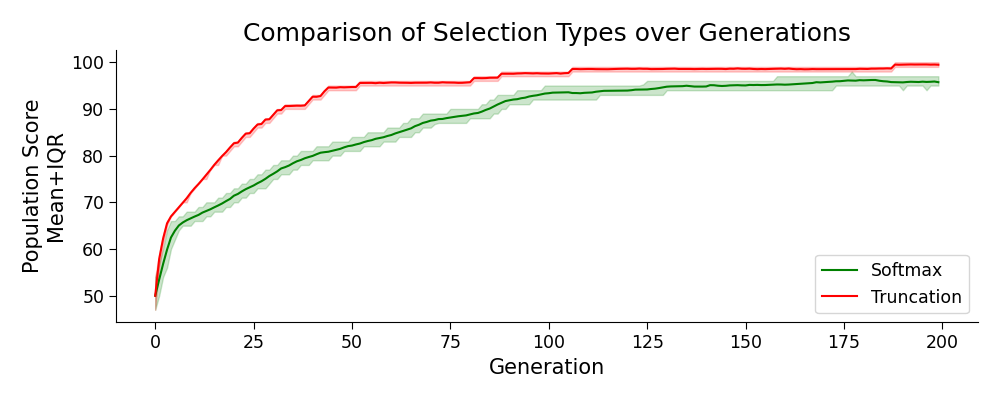

In [5]:
# to_remove solution

fig, ax = plt.subplots(figsize=(10, 4))

softmax_params = {
    'selection_type': 'softmax',
    'color': 'green',
    'label': 'Softmax',
    'softmax_temp': 7,
}
truncation_params = {
    'selection_type': 'deterministic truncation',
    'color': 'red',
    'label': 'Truncation',
    'truncation_threshold': .9,
}

plot_selection_results(ax, **softmax_params, **common_params)
plot_selection_results(ax, **truncation_params, **common_params)

ax.set_xlabel('Generation')

ax.set_xlabel('Generation')
ax.set_ylabel('Population Score\nMean+IQR')
ax.set_title('Comparison of Selection Types over Generations')
ax.legend()

remove_ip_clutter(fig)
plt.show()

## Reflection Question: Speed of Selection and Population Variance

1. Is there a relationship between the speed at which different selection types reach the optimal genotype and the variance in population score, as indicated by the relative width of the shaded interquartile regions in the figures above?


<details>
  <summary>Answer</summary>
  Yes, stronger forms of selection, i.e., those that achieve the optimal genotype more quickly, tend to have less variation in the population score.
</details>

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.3.1.2: Mutation Rate, Population Size and Rate of Adaptation

So now we know that strength of selection is important, what about population size and mutation? Let's simulate and see! Mutation rate first. While you're waiting for the simulations to run, think about think about what different mutation rates might do to the speed of the evolutionary process.

## Simulation: Mutation Rate and Speed of Adaptation

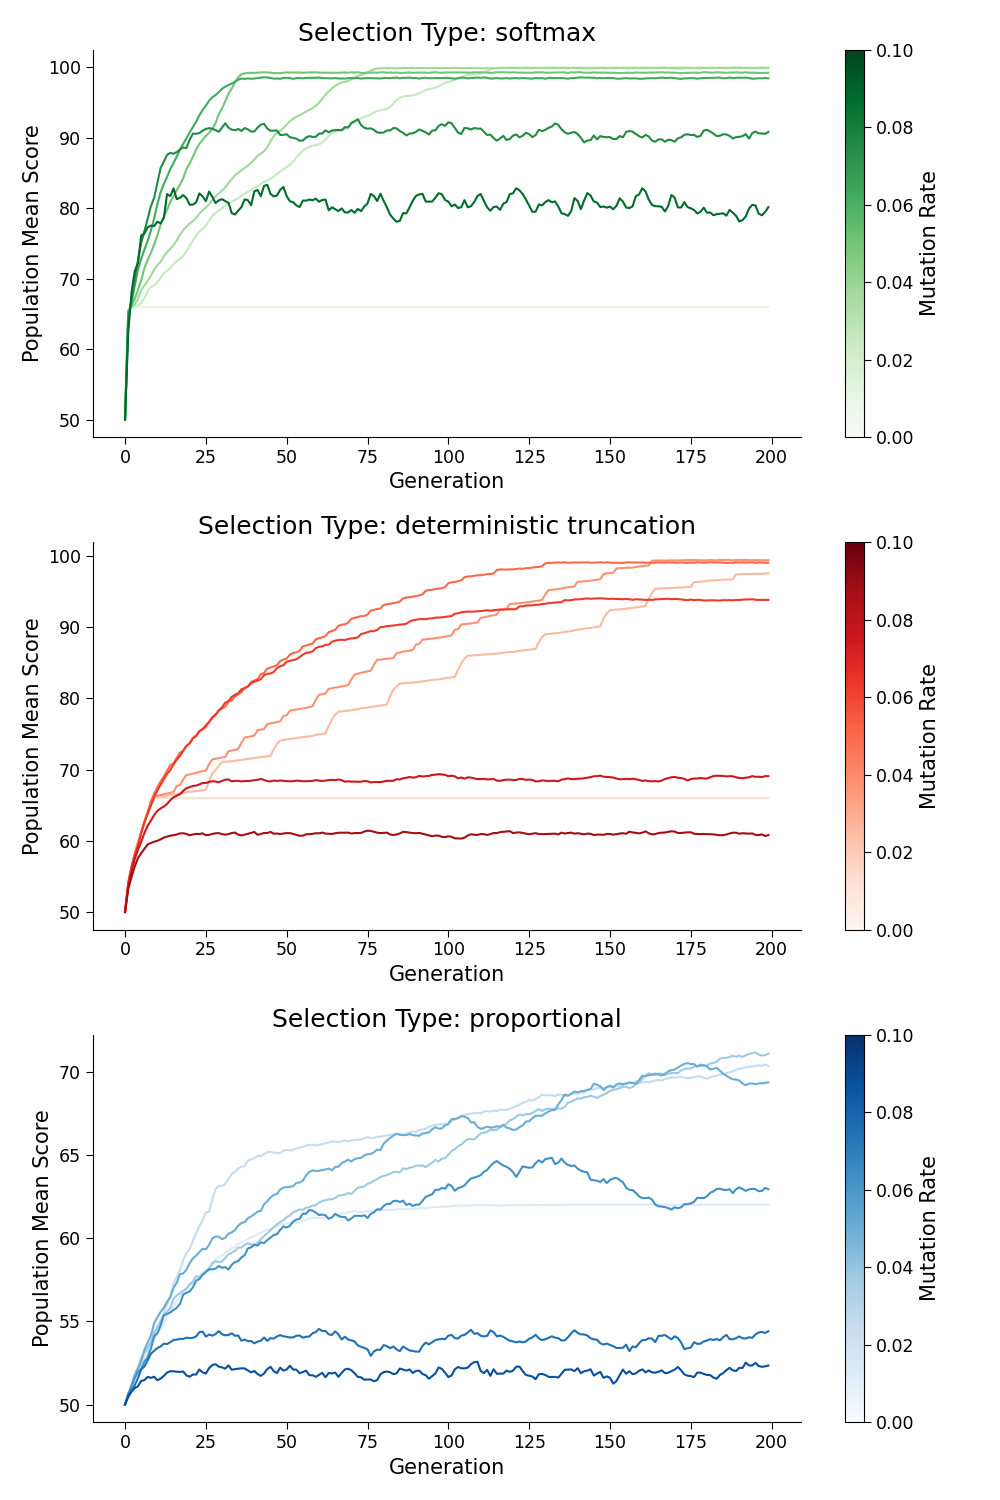

In [6]:
#@markdown **Run this cell** to use the simulation method we created above to explore how mutation rate impacts rate of evolution for different kinds of selection.

# simulation and plotting functions defined here again in case coding exercise
# not completed

def selection_type_simulation(pop_size=1000, n_gen=100, n_rcpt=100,
                              mutation_rate=0.005, has_mutation=True,
                              has_recombination=False, has_assortative_pairing=True,
                              selection_type='proportional', #softmax, deterministic truncation, proportional truncation
                              softmax_temp=1, truncation_threshold=0.5,
                              seed=None, init_pop='simple'): # mutation_eq, recomb_eq
  """
  Simulates the evolutionary process in a population of genotypes playing the
  Strike-No-Strike game using different types of selection.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  # Initialize population
  if init_pop == 'simple':
    population = rng.integers(0, 2, size=(pop_size, n_rcpt),
                              dtype=np.bool_)
  elif init_pop != 'simple':
    # for agreement with theoretical models we initialize population so that
    # variance starts at 'dynamic equilibrium' level
    if init_pop == 'mutation_eq':
      # Calculate n' and b
      n_prime = int(2 * mutation_rate * n_rcpt * (np.pi - 2))
      b = int(n_rcpt * (-2 * np.pi * mutation_rate + 4 * mutation_rate + 1) / 2)
    elif init_pop == 'recomb_eq':
      n_prime = int(n_rcpt*(np.pi - 2) / (2 + np.pi))
      b = int(2 * n_rcpt / (2 + np.pi))
    # Generate shifted binomial distribution
    num_ones = rng.binomial(n_prime, 0.5, size=pop_size) + b
    population = np.zeros((pop_size, n_rcpt), dtype=np.bool_)
    # Assign '1's randomly for each population member
    for i in range(pop_size):
      one_positions = rng.choice(n_rcpt, num_ones[i], replace=False)
      population[i, one_positions] = True

  # Track statistics genotype scores over generations.
  mean_hist = np.zeros(n_gen)
  mean_after_sel_hist = np.zeros(n_gen)
  var_hist = np.zeros(n_gen)
  skew_hist = np.zeros(n_gen)
  lower_quartile_hist = np.zeros(n_gen)
  upper_quartile_hist = np.zeros(n_gen)

  for generation in range(n_gen):
    # Calculate scores for each genotype
    scores = np.sum(np.array(population, dtype=float), axis=1)

    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0
    # Track statistics genotype scores over generations.
    mean_hist[generation] = mean_
    var_hist[generation] = var_
    skew_hist[generation] = skew_
    lower_quartile_hist[generation] = np.percentile(scores, 25)
    upper_quartile_hist[generation] = np.percentile(scores, 75)

    # Calculate fitness for each genotype

    # Selective Reproduction
    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(scores) # this line as exercise
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp) # this line
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)  # and this line as exercise
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      # Deterministic truncation selection
      selected = scores >= np.quantile(scores, truncation_threshold) # this line as exercise
      selected_indices = np.arange(len(scores))[selected]
      # Create the new population
      new_population = []
      base_replication_count = int(pop_size / len(selected_indices))
      additional_replications = pop_size % len(selected_indices)
      for idx in selected_indices:
        new_population.extend([population[idx]] * base_replication_count) # this line as exercise
      # If there are additional replications needed, add the highest scoring individuals
      if additional_replications > 0:
        sorted_selected_indices = selected_indices[np.argsort(-scores[selected])]
        new_population.extend([population[idx] for idx in sorted_selected_indices[:additional_replications]])
      population = np.array(new_population)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")
    if selection_type != 'deterministic truncation':
      population = rng.choice(population, size=pop_size, p=prob_scores) # this line as exercise

    post_selection_score = np.sum(np.array(population, dtype=float), axis=1)
    mean_after_sel_hist[generation] = np.mean(post_selection_score)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population.shape) < mutation_rate
      population ^= mutation_mask

    # recombination
    if has_recombination:
      # Shuffle the indices of the population
      shuffled_indices = rng.permutation(pop_size)
      shuffled_population = population[shuffled_indices]
      #mating can be assortative or totally random
      if has_assortative_pairing:
        shuffled_scores = np.sum(np.array(shuffled_population, dtype=float), axis=1)
        # Sort the shuffled population based on scores for assortative mating
        sorted_indices = np.argsort(shuffled_scores)
        sorted_population = shuffled_population[sorted_indices]
        # Reshape sorted population to group similar parents into pairs
        parent_pairs = sorted_population.reshape(pop_size // 2, 2, n_rcpt)
      else:
        # Reshape shuffled population to group similar parents into pairs
        parent_pairs = shuffled_population.reshape(pop_size // 2, 2, n_rcpt)

      # The rest of your recombination process remains the same
      mask1 = rng.integers(0, 2, size=(pop_size // 2, n_rcpt)).astype(np.bool_)
      mask2 = rng.integers(0, 2, size=(pop_size // 2, n_rcpt)).astype(np.bool_)

      children = np.empty_like(parent_pairs)
      children[:, 0, :] = np.where(mask1, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      children[:, 1, :] = np.where(mask2, parent_pairs[:, 0, :], parent_pairs[:, 1, :])

      population = children.reshape(pop_size, n_rcpt)

  return mean_hist, mean_after_sel_hist, var_hist, skew_hist, upper_quartile_hist, lower_quartile_hist


def plot_selection_results(ax, selection_type, n_gen, color, label, seed,
                           softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=0.005, pop_size=1000,
                           plot_IQR=True, init_pop='simple'):
    (mean_hist, mean_after_sel_hist, var_hist, skew_hist,
     upper_quartile_hist, lower_quartile_hist) = selection_type_simulation(
        selection_type=selection_type,
        n_gen=n_gen,
        seed=seed,
        softmax_temp=softmax_temp,
        truncation_threshold=truncation_threshold,
        mutation_rate=mutation_rate,
        pop_size=pop_size,
        init_pop=init_pop
    )
    generations = np.arange(n_gen)
    if plot_IQR:
      ax.fill_between(generations, lower_quartile_hist, upper_quartile_hist,
                      color=color, alpha=0.2)
    ax.plot(generations, mean_hist, color=color, label=label)




# Parameters
n_gen = 200
seed = 123
mutation_rates = [0.00, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]  # Example mutation rates
pop_size = 1000  # Example population size

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for each selection type
selection_types = ['softmax', 'deterministic truncation', 'proportional']
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}
for ax, selection_type in zip(axs, selection_types):
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(mutation_rates)
  colors = [base((i+1)/(num_shades+1)) for i in range(num_shades)]

  norm = matplotlib.colors.Normalize(vmin=min(mutation_rates), vmax=max(mutation_rates))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  for mutation_rate, color in zip(mutation_rates, colors):
    label = f'Mutation Rate {mutation_rate}'
    plot_selection_results(ax, selection_type, n_gen, color, label, seed,
                           mutation_rate=mutation_rate, pop_size=pop_size,
                           plot_IQR=False)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Population Mean Score')
  #ax.legend()
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Mutation Rate')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

Across all three selection types we observe a similar pattern. Very high mutation rates (darker shades) lower the final average population score and prevent the optimal genotype from being achieved. In these cases selection can not sort through all the new variation mutation is generating fast enough to maintain a high population score. In contrast lower mutation rates result in a higher final average score, but if the mutation rate is very low, it can take longer for the evolutionary process to find the optimal solution. In this case the rate of introduction of new variation to be tested by selection is constraining and slowing down the process. This is seen most clearly in the case when there is no mutation, and the population converges on one of the best genotypes in the initial population, but can improve no further once that initial variation is used up. So both too little and too much mutation can result in a slower optimization. Evolutionary processes need some but not too much mutation to effectively find optimal solutions.

Now let's take a look at the impact of population size. While you're waiting for the simulations to run, think about what different population sizes might do to the speed of the evolutionary process.

## Simulation: Population Size and Speed of Adaptation

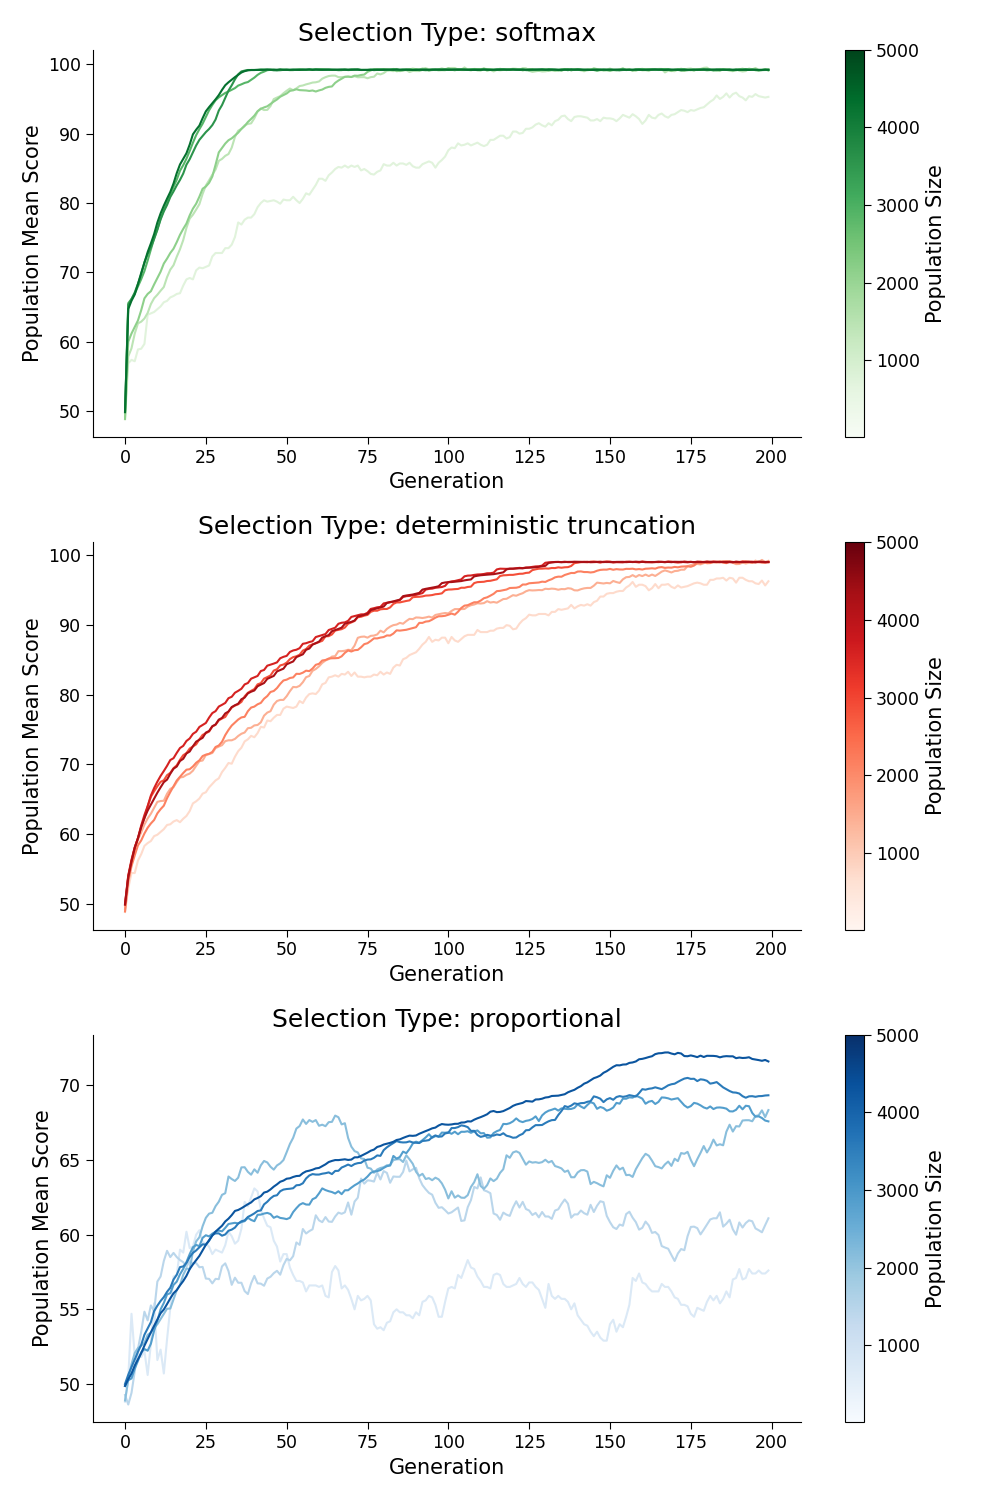

In [7]:
#@markdown **Run this cell** to use the simulation method we created above to explore how population size impacts rate of evolution for different kinds of selection.


# Parameters
n_gen = 200
seed = 123
population_sizes = [10, 50, 100, 500, 1000, 5000]  # Example population sizes

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for each selection type
selection_types = ['softmax', 'deterministic truncation', 'proportional']
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}

for ax, selection_type in zip(axs, selection_types):
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(population_sizes)
  colors = [base((i+1)/(num_shades+1)) for i in range(num_shades)]

  norm = matplotlib.colors.Normalize(vmin=min(population_sizes), vmax=max(population_sizes))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  for pop_size, color in zip(population_sizes, colors):
    label = f'Pop Size {pop_size}'
    plot_selection_results(ax, selection_type, n_gen, color, label, seed,
                           pop_size=pop_size, plot_IQR=False)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Population Mean Score')
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Population Size')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

In every selection process, a very small population slows the improvement of the population score. And for proportional selection, small population basically halts progression (weak selection cannot overcome genetic drift). However, beyond a critical population size, further increases in population size seem to barely affect the rate of adaptation. This phenomenon is rooted in the fundamental nature of selection, which acts on the heritable variation of traits within a population. Beyond a certain threshold, a larger population size doesn't provide (meaningfully) more variation. To understand this, consider the effect of sample size on estimates of variance in statistics: The variance of a sample is defined as $\frac{1}{N} \sum_{i=1}^{N}(x_i - \bar{x})^2$ where $\bar{x}$ is the sample mean. Using this raw, or empirical variance, will provide a biased (under) estimate of the true variance of the underlying random variable, which is why $\frac{1}{N-1} \sum_{i=1}^{N-1}(x_i - \bar{x})^2$ is used as an estimate for the true variance. The difference between $\frac{1}{N-1} - \frac{1}{N}$ is on the order of $\frac{1}{N^2}$. Similarly, incremental increase in variation for selection to act on provided by additional individuals diminishes rapidly. Only very small population sizes significantly limit variation reduce the efficiency of the selection process.

In the case of proportional selection, where the strength of selection is weak, a large population does appear to accelerate adaptation, however this has more to do with a large population size counteracting the stochasticity introduced by random drift.


In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.3.1.3 Model of Selection

We have mentioned already that selection acts on heritable variation. The following analyses aims to solidify and make clear precisely what is meant by this statement.

Suppose that the score $z(t)$ is normally distributed in the population at generation $t$ with mean $\mu(t)$ and variance $\sigma^2(t)$, and that as in our simulations, the trait $z$ is perfectly passed on from parent to offspring (if there is no mutation). Then we can ask what will the mean $\mu(t+1)$ and variance $\sigma^2(t+1)$ of the child population look like after one generation of truncation selection (with truncation threshold 0.5). For a normal distribution it is known (and easy but tedious to work out) that when taking the top half of a normal distribution the resulting mean and variance of the new distribution are given by:

$$ \mu(t+1) = \mu(t) + \sqrt{\frac{2}{\pi}} \sigma(t)$$
and
$$ \sigma^2(t+1) = \sigma^2(t) \left(1-\frac{2}{\pi}\right).$$

Immediately we can see that selection is increasing the mean value of the trait by an amount proportional to the standard deviation (the root of the variance) in the trait, while simultaneously decreasing the variation in the trait by an amount that is also proportional (with a different constant) to the existing variation in the trait.

A similar pattern holds for proportional selection and can be derived (with some effort) from the definitions of mean, variance and skew.

$$ \mu(t+1) = \mu(t) + \frac{\sigma^2(t)}{\mu(t)}$$
and
$$ \sigma^2(t+1) = \sigma^2(t) \left(1 + \frac{\gamma(t) \sigma(t)}{\mu(t)} -\frac{\sigma^2(t)}{\mu(t)^2}\right) $$

Here $\gamma(t)$ is the skew in the population distribution of $z$ at generation $t$. Although the details are different we see that again selection is increasing the mean value of the trait by an amount proportional to the variance of the trait, and decreasing the variance by an amount proportional to the variance. Variation can also be increased or decreased depending on the skew of the distribution. If the population is skewed in the direction of selection ($\gamma >0$), i.e. there is a thicker tail on the right, then selection will increase the frequency of these rare variants which will contribute to an increase in variation. In contrast if the population is skewed to so that the tail is thicker on the left ($\gamma < 0$) selection will decrease the frequency of these rare variants and thereby further reduce variation.

We can also see that unlike the truncation selection case, with proportional selection these increments are scaled by the population mean $\mu$ showing how the strength of selection diminishes as the baseline score becomes greater.

**Bonus Exercise:**
Derive the formulas given above for the change in mean and variance due to truncation and proportional selection.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# 1.3.1.4 Model of Mutation

From the above it is clear that selection can be viewed as a process that increases the average fitness score (average fitness in the strict relative sense is always constant) proportional to the existing variation in the population while simultaneously decreasing the population variation in fitness score. If selection is the engine of evolution, variation is the fuel. Mutation is one way in which new variation can be injected into the population, and as we saw in the simulations of the previous section when mutation is set to zero and no new variation in introduced the evolutionary processes grinds to a halt.  As we did above with selection, let's think about what the effects of mutation are on the mean and variance of the score distribution $z$ from one generation to the next.

If a parent has score $z$, and $m$ is the per bit mutation rate and $n$ is the total number of bits in the part of the genotype being modeled, then, with mutation the child score will be the sum of the parent's $z$ value less the number of 'good' bits, there are $z$, that mutate to 'bad' bits plus the number of 'bad' bits, there are ($n - z$), that flip to 'good' so
$$z_\text{child} \sim z_{\text{parent}} - \text{Bin}\left(z, m\right) + \text{Bin}(n-z, m)$$

So
$$E[z_\text{child}] = z_\text{parent} + (n-2z_\text{parent})m = nm + z_\text{parent}(1-2m)$$
and
$$Var[z_\text{child}] = Var[z_\text{parent}] + nm(1-m) \approx Var[z_\text{parent}] + nm $$

Note that the error introduced by that approximation is small when $m$ is small and $1-m \approx 1$. These expressions are somewhat easier to interpret when working with the excess fitness score defined as$ \delta := z - \frac{n}{2} $ so that

$$E[\delta_\text{child}] = \delta_\text{parent}(1-2m)$$
and
$$Var[\delta_\text{child}] = Var[\delta_\text{parent}] + nm$$

We can then combine the effects of selection and mutation by thinking of $\delta_\text{parent}$ as a random variable drawn from the population of the previous generation according to our selection rule. We will focus on the case of truncation selection assuming an approximately normal distribution of $\delta$. When combining selection and mutation we have the option to write out the dynamics of the distribution $\delta$ from one generation to the next either in terms of selection and then mutation, or mutation and then selection. Although the overall dynamics of each form will be equivalent, measures of fitness score mean will be higher if taken after selection and lower if taken after mutation, and conversely measures of score variance will be lower if taken after selection and higher if taken after mutation. The choice is arbitrary but the equations come out more cleanly if we choose to view the dynamics from a mutation then selection perspective. To simplify the analysis, we will write the variance of the parent generation (the previous generation after selection) in terms the variation injected by the mutation process, i.e. we choose $\beta(t)$ such that $\sigma^2(t) := \beta(t) nm $. Putting this all together we have our 'equations of motion' for evolution by truncation selection with mutation (assuming a normally distributed fitness score in the parent population):

$$\mu(t+1) = (1-2m) \mu(t) + \sqrt{\frac{2}{\pi}}\sqrt{nm(\beta+1)}$$
and
$$\sigma^2(t+1) = nm (\beta + 1)  \left(1-\frac{2}{\pi}\right)$$

Here $\mu$ and $\sigma^2$ are the population mean and variance of $\delta$ after mutation and selection.

This can be further simplified  by the assumption that variance is in 'dynamic equilibrium', i.e. that the variance being added by mutation on any given generation is roughly equal to the variance being removed by selection so that $\sigma^2(t+1) \approx \sigma^2(t) = nm\beta$. This implies that $\beta \approx \frac{\pi}{2} -1$ for small mutation rate $m$ and that

$$\mu(t+1) = (1-2m)\mu(t) + \sqrt{nm}$$
or equivalently
$$ \Delta \mu = \sqrt{nm} - 2m\mu$$

Now $\delta$ is constrained to be between $\frac{-n}{2}$ and $\frac{n}{2}$, so our model here predicts a viable equilibrium value $\mu^* = \sqrt{\frac{n}{m}}$ when $nm > 1$, but makes unrealistic predictions of equilibrium fitness scores greater than the theoretical maximum of $n$ when $nm < 1$. This is because our selection by truncation using a normal approximation always assumes that there are higher fitness score individuals to be selected and does not account for the hard cap imposed by our underlying fitness score function $z(g)$. As we will see in the simulations below, the normal approximation matches the simulated dynamics quite well up to the point where this boundary condition is violated.

## Coding Exercise: Implement Mathematical Model of Selection and Mutation

In [ ]:
################################################################################
# TODO for students: Use our analysis above to implement our theoretical
# mutation model
raise NotImplementedError("Exercise: Implement our mutation model")
################################################################################


def mutation_truncation_model(n_rcpt, n_gen, mutation_rate, mu_0 = 0):
  mu = mu_0
  mean_hist = np.zeros(n_gen)
  for generation in range(n_gen):
    mean_hist[generation] = mu + n_rcpt/2 #convert delta to z for plotting
    delta_mu = ...
    mu += delta_mu
  return mean_hist


def compare_mutation_theory_sim(per_geno_mutation_rates, n_gen=200, n_rcpt=100, pop_size=1000):
  mutation_rates = np.array(per_geno_mutation_rates) / n_rcpt
  fig, ax = plt.subplots(figsize=(10, 6))

  num_shades = len(mutation_rates)
  base_color_map = matplotlib.colormaps['Reds']
  colors = [base_color_map((i+1)/(num_shades+1)) for i in range(num_shades)]
  custom_lines = [matplotlib.lines.Line2D([0], [0], color='black', linestyle='-'),
                  matplotlib.lines.Line2D([0], [0], color='black', linestyle='--')]

  for mutation_rate, color in zip(mutation_rates, colors):
    # Run the theoretical model
    theoretical_mean_hist = mutation_truncation_model(n_rcpt, n_gen, mutation_rate)
    # Run the simulation model
    simulation_results = selection_type_simulation(pop_size=pop_size, n_gen=n_gen,
                                                   n_rcpt=n_rcpt, mutation_rate=mutation_rate,
                                                   selection_type='deterministic truncation',
                                                   truncation_threshold=0.5,
                                                   init_pop='mutation_eq')
    simulated_mean_hist = simulation_results[1]
    # Plotting
    ax.plot(theoretical_mean_hist, color=color, linestyle='--', label=f"Theory (Mutation rate: {mutation_rate})")
    ax.plot(simulated_mean_hist, color=color, label=f"Simulation (Mutation rate: {mutation_rate})")

  # Set titles and labels
  ax.set_title("Comparison of Theoretical and Simulated Models Across Mutation Rates")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")
  ax.legend()
  remove_ip_clutter(fig)
  plt.tight_layout()
  plt.show()

per_geno_mutation_rates = [2.0, 0.5, 0.05]
compare_mutation_theory_sim(per_geno_mutation_rates, n_gen=500)

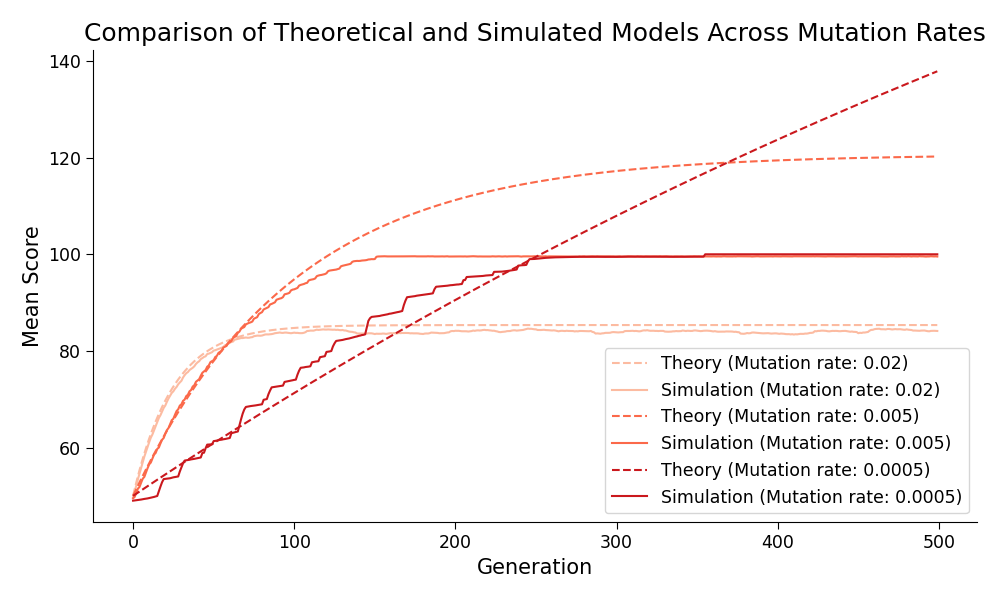

In [8]:
# to_remove solution


def mutation_truncation_model(n_rcpt, n_gen, mutation_rate, mu_0 = 0):
  mu = mu_0
  mean_hist = np.zeros(n_gen)
  for generation in range(n_gen):
    mean_hist[generation] = mu + n_rcpt/2 #convert delta to z for plotting
    delta_mu = np.sqrt(n_rcpt*mutation_rate) - 2*mutation_rate*mu
    mu += delta_mu
  return mean_hist


def compare_mutation_theory_sim(per_geno_mutation_rates, n_gen=200, n_rcpt=100, pop_size=1000):
  mutation_rates = np.array(per_geno_mutation_rates) / n_rcpt
  fig, ax = plt.subplots(figsize=(10, 6))

  num_shades = len(mutation_rates)
  base_color_map = matplotlib.colormaps['Reds']
  colors = [base_color_map((i+1)/(num_shades+1)) for i in range(num_shades)]
  custom_lines = [matplotlib.lines.Line2D([0], [0], color='black', linestyle='-'),
                  matplotlib.lines.Line2D([0], [0], color='black', linestyle='--')]

  for mutation_rate, color in zip(mutation_rates, colors):
    # Run the theoretical model
    theoretical_mean_hist = mutation_truncation_model(n_rcpt, n_gen, mutation_rate)
    # Run the simulation model
    simulation_results = selection_type_simulation(pop_size=pop_size, n_gen=n_gen,
                                                   n_rcpt=n_rcpt, mutation_rate=mutation_rate,
                                                   selection_type='deterministic truncation',
                                                   truncation_threshold=0.5,
                                                   init_pop='mutation_eq')
    simulated_mean_hist = simulation_results[1]
    # Plotting
    ax.plot(theoretical_mean_hist, color=color, linestyle='--', label=f"Theory (Mutation rate: {mutation_rate})")
    ax.plot(simulated_mean_hist, color=color, label=f"Simulation (Mutation rate: {mutation_rate})")

  # Set titles and labels
  ax.set_title("Comparison of Theoretical and Simulated Models Across Mutation Rates")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")
  ax.legend()
  remove_ip_clutter(fig)
  plt.tight_layout()
  plt.show()

per_geno_mutation_rates = [2.0, 0.5, 0.05]
compare_mutation_theory_sim(per_geno_mutation_rates, n_gen=500)

We can see from the comparison with simulation that our theory roughly captures the scale of the changes in mean fitness score driven by selection up until the point when the assumptions of the model (normally distributed fitness score) fall apart, which they do as the mean fitness score approaches its theoretical maximum.

The main values of the math exercise above is to have this equation
$$ \Delta \mu = \sqrt{nm} - 2m\mu$$
which help us to think about what selection and mutation are doing. From the positive $\sqrt{nm}$ term in this equation we can that the increases in fitness due to selection is ultimately constrained by the rate at which new variation is introduced by mutation. From the negative term $-2m \mu$ we see that mutation has a fitness score cost which grows as the fitness score increases, and the chances of deleterious mutation increase. This begs the question, is there some way of creating variation in a population for selection to act on that is less costly than mutation. The answer is yes. Sex, or more broadly recombination and genetic exchange, is such a powerful enhancer of adaptation that is is used ubiquitously by virtually all of life!

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# 1.3.1.5 Model of Sex (Recombination)

In keeping with our previous analysis we continue to work with truncation selection but now we consider a different source of variation in the population, recombination a.k.a. sex. We model recombination as follows. After selection, individuals in the population form $M = \frac{N}{2}$ pairs. These pairs produce offspring whose genotypes (or bit-strings) $g$ are a random 'bit-wise' recombination of the parent genomes. (This is major simplification and not closely connected to any of the many ways recombination is typically executed in real living systems, but nevertheless it suffices to illustrate the efficacy of recombination.) Each child genotype $g'$ is then a random mix of the genotype of the first parent $g^1$ and the second parent $g^2$, so that the $i^{\text{th}}$ bit of the child genotype $g'_i$ is equally likely to come from one of the two parents, that is:
$$g'_i = \begin{cases}
  g_i^1 & \text{with probability 1/2}\\
  g_i^2 & \text{with probability 1/2}.\\
\end{cases}$$

Now as before we ask what does this recombination process do to the mean and variance of the population distribution of fitness score? To simplify our analysis we assume that mating is assortative, so that both parents will have roughly the same number of good bits, though, and this is important, not necessarily the same good bits, in their genomes, i.e. $\sum_{i=1}^n g_i^1 = \sum_{i=1}^n g_i^2 = z$. Additionally, other than this assortative mating on score we assume that mating is otherwise well mixed so there is no correlation between which bits are good or bad between the parents. Then, using $f:= \frac{z}{n}$ as the normalized fitness score, the number of bits that are good in both parents is approximately $nf^2 $, the number of bits where one parent has the good bit but the other parent has the bad bit will be roughly $2nf(1-f)$ and the number of bits where neither parent has the good bit will be roughly $n(1-f)^2$. (These quantities are all actually the realization of a multinomial random variable with $n$ trials $k=3$ distinct outcomes and probabilities $f^2$, $2f(1-f)$, and $((1-f)^2$, but to simplify our model we ignore the variance introduced by the multinomial sample and approximate these random variables with their expected values.) So the child's fitness score will be roughly $nf$ from the loci where both parents have the 'good' allele plus a draw from a binomial random variable with $2nf(1-f)$ trials and probability $0.5$ of success for the loci where exactly one parent has the 'good' allele. For large $n$ the normal approximation of such a binomial is good, so we have
$$z_\text{child} \sim N\left(\text{mean}=z, \text{variance}=\frac{nf(1-f)}{2}\right).$$

where $z$ is the parent score, and $f=\frac{z}{n}$ is the normalized parent score. Note that unlike mutation which reduces the mean fitness score of children, with recombination the mean fitness of the children is equal to that of the parents. Now we want to put recombination together with selection and see what the resulting effect on the distribution of fitness score is. As in the mutation analysis we will write out the dynamics in terms of recombination and then selection, and we will re-write the variance of the parent population in terms of the variance added by recombination, i.e. we define $\sigma^2(t) = \beta(t) \frac{n\bar{f}(t)(1-\bar{f}(t))}{2}$, where $\bar{f}(t)$ is the normalized mean fitness score, i.e. $\bar{f}(t) = \frac{\mu(t)}{n}$. Then the distribution of $z$ in the child population (after recombination but before selection) is approximately

$$z_\text{child} \sim N\left(\text{mean}=\mu(t), \text{variance}=\left( 1 + \beta(t) \left(1-\frac{1}{2n}\right) \right)\frac{n\bar{f}(t)(1-\bar{f}(t))}{2}\right).$$

Now for large $n$ we have $1\approx 1- \frac{1}{2n}$ so we can use

$$z_\text{child} \sim N\left(\text{mean}=\mu(t), \text{variance}=\left( 1 + \beta(t) \right)\frac{n\bar{f}(t)(1-\bar{f}(t))}{2}\right).$$

Putting this all together, and recalling that truncation selection increase the mean by an increment of $\sqrt{\frac{2}{\pi}}$ times the standard deviation, and that it contracts variance by a factor of $1-\frac{2}{\pi}$, we have our 'equations of motion' for evolution by truncation selection and recombination (assuming a normally distributed fitness score in the parent population):

$$\mu(t+1) = \mu(t) + \sqrt{\frac{2}{\pi}}\sqrt{\left(1+\beta(t)\right) \frac{n \bar{f}(t) (1-\bar{f}(t))}{2}}$$

and

$$ \sigma^2(t+1) = \left(1-\frac{2}{\pi}\right)\left(\left(1+\beta(t)\right) \frac{n \bar{f}(t) (1-\bar{f}(t))}{2}\right).$$

As in our mutation analysis we again make the assumption of 'dynamic equilibrium', i.e. that in each generation selection burns through about as much variation as recombination adds. Then in this equilibrium $\beta = \frac{(\pi -2)}{2}$ which gives us
$$ \Delta \mu = \sqrt{\frac{nf(1-f)}{2}}$$

Here the model predicts that mean fitness score will always increase, slowing down as it reaches equilibrium at the peak theoretical fitness score of $n$. This approximation agrees well with the corresponding simulation as can be seen below.

## Coding Exercise: Implement Mathematical Model of Selection and Recombination

In [9]:
################################################################################
# TODO for students: Use our analysis above to implement our theoretical
# recombination model
raise NotImplementedError("Exercise: Implement our recombination model")
################################################################################


def recombination_truncation_model(n_rcpt, n_gen):
  mu = n_rcpt*0.5
  mean_hist = np.zeros(n_gen)
  for generation in range(n_gen):
    mean_hist[generation] = mu
    f = mu/n_rcpt
    if f >= 1.0:
      delta_mu = 0
    else:
      delta_mu = ...
    mu += delta_mu
  return mean_hist


def compare_recomb_theory_sim(n_gen=500, n_rcpt=100, pop_size=1000, mutation_rate=None):
  if mutation_rate==None:
    mutation_rate = 1 / n_rcpt

  fig, ax = plt.subplots(figsize=(12, 8))

  # Theoretical recombination model
  theory_recomb1 = recombination_truncation_model(n_rcpt, n_gen)

  # Simulated recombination model
  simul_recomb_results = selection_type_simulation(
        pop_size=pop_size, n_gen=n_gen, n_rcpt=n_rcpt,
        has_mutation=False, has_recombination=True,
        selection_type='deterministic truncation', truncation_threshold=0.5,
        init_pop='recomb_eq')
  simul_recomb_mean_hist = simul_recomb_results[1]

  # Plotting
  ax.plot(theory_recomb1, color='blue', linestyle='--', label='Theory Recombination')
  ax.plot(simul_recomb_mean_hist, color='blue', label='Simulated Recombination')

  # Set titles and labels
  ax.set_title("Comparison of Theoretical and Simulated Recombination and Mutation")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")

  # Adjust legend
  ax.legend()
  plt.tight_layout()
  remove_ip_clutter(fig)
  plt.show()

compare_recomb_theory_sim(n_gen=30)

NotImplementedError: Exercise: Implement our recombination model

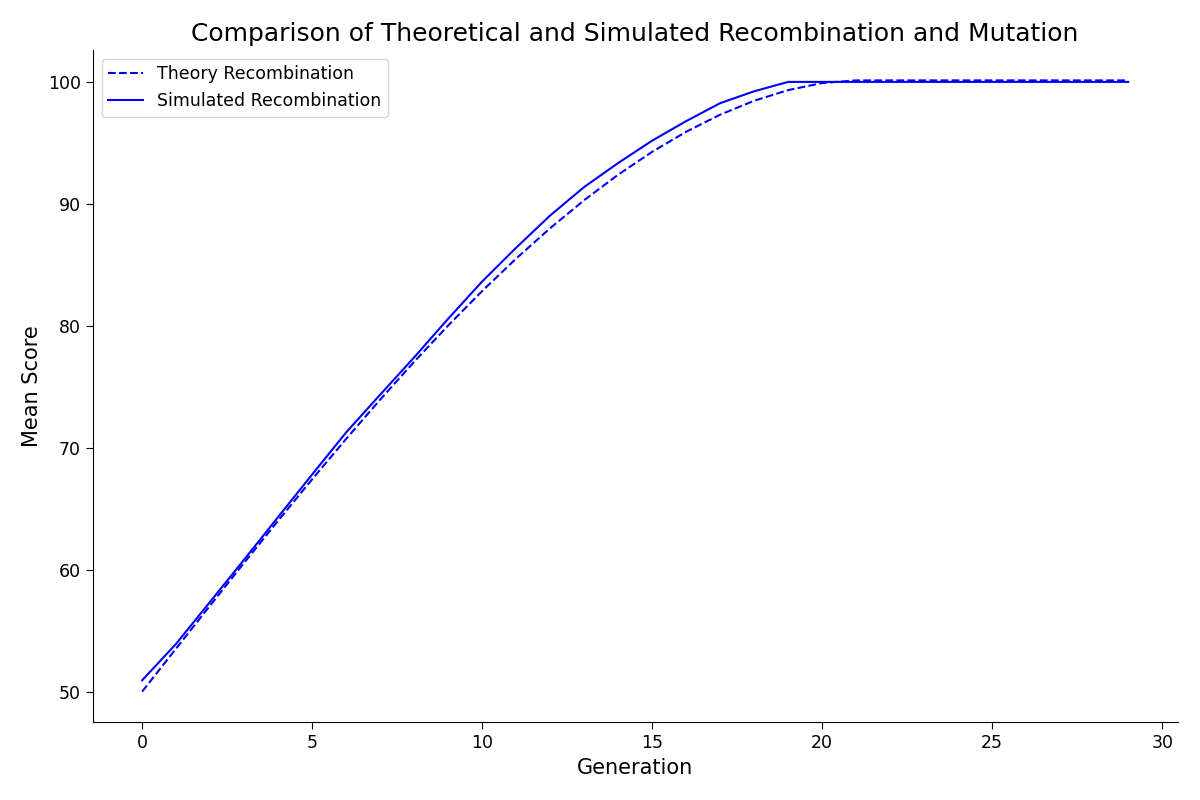

In [10]:
# to_remove solution


def recombination_truncation_model(n_rcpt, n_gen):
  mu = n_rcpt*0.5
  mean_hist = np.zeros(n_gen)
  for generation in range(n_gen):
    mean_hist[generation] = mu
    f = mu/n_rcpt
    if f >= 1.0:
      delta_mu = 0
    else:
      delta_mu = np.sqrt(n_rcpt*f*(1-f)/2)
    mu += delta_mu
  return mean_hist


def compare_recomb_theory_sim(n_gen=500, n_rcpt=100, pop_size=1000, mutation_rate=None):
  if mutation_rate==None:
    mutation_rate = 1 / n_rcpt

  fig, ax = plt.subplots(figsize=(12, 8))

  # Theoretical recombination model
  theory_recomb1 = recombination_truncation_model(n_rcpt, n_gen)

  # Simulated recombination model
  simul_recomb_results = selection_type_simulation(
        pop_size=pop_size, n_gen=n_gen, n_rcpt=n_rcpt,
        has_mutation=False, has_recombination=True,
        selection_type='deterministic truncation', truncation_threshold=0.5,
        init_pop='recomb_eq')
  simul_recomb_mean_hist = simul_recomb_results[1]

  # Plotting
  ax.plot(theory_recomb1, color='blue', linestyle='--', label='Theory Recombination')
  ax.plot(simul_recomb_mean_hist, color='blue', label='Simulated Recombination')

  # Set titles and labels
  ax.set_title("Comparison of Theoretical and Simulated Recombination and Mutation")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")

  # Adjust legend
  ax.legend()
  plt.tight_layout()
  remove_ip_clutter(fig)
  plt.show()

compare_recomb_theory_sim(n_gen=30)

In just roughly 20 generation the population with variation derived from recombination is able to converge on the optimal genotype (all 1's). This is in stark contrast with a population where variation is derived from mutation alone, as can be seen in the simulation below.

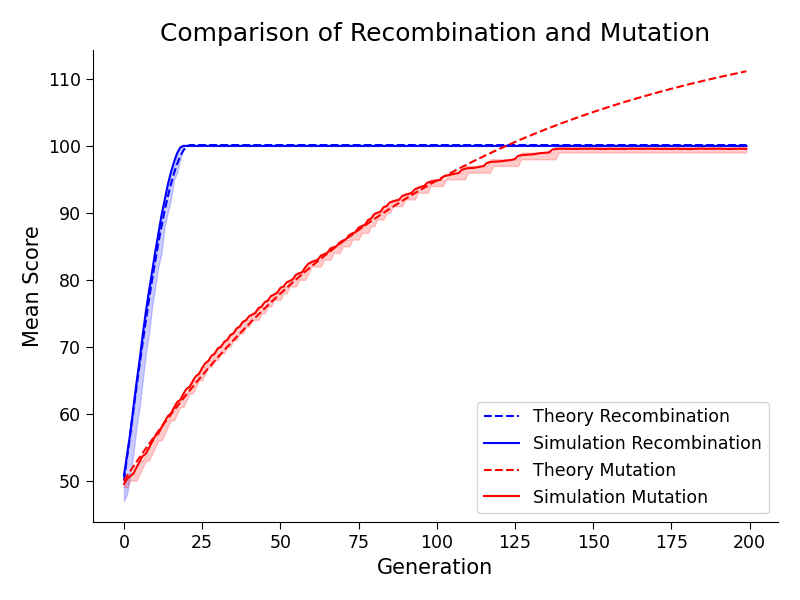

In [11]:
# @markdown **Run this cell** to compare mutation and recombination.


def compare_recomb_mutation_theory_sim(n_gen=1000, n_rcpt=100, pop_size=1000, mutation_rate=None):
  if mutation_rate==None:
    mutation_rate = 0.5 * (1 / n_rcpt)

  fig, ax = plt.subplots(figsize=(8, 6))

  # Theoretical recombination model
  theory_recomb1 = recombination_truncation_model(n_rcpt, n_gen)

  # Simulated recombination model
  simul_recomb_results = selection_type_simulation(
        pop_size=pop_size, n_gen=n_gen, n_rcpt=n_rcpt,
        has_mutation=False, has_recombination=True,
        selection_type='deterministic truncation', truncation_threshold=0.5,
        init_pop='recomb_eq')
  simul_recomb_mean_hist = simul_recomb_results[1]
  simul_recomb_lower_quartile_hist = simul_recomb_results[5]
  simul_recomb_upper_quartile_hist = simul_recomb_results[4]

  # Theoretical mutation model
  theory_mutant_mean_hist = mutation_truncation_model(n_rcpt, n_gen, mutation_rate)

  # Simulated mutation model
  simul_mutation_results = selection_type_simulation(
        pop_size=pop_size, n_gen=n_gen, n_rcpt=n_rcpt,
        has_mutation=True, mutation_rate=mutation_rate, has_recombination=False,
        selection_type='deterministic truncation', truncation_threshold=0.5,
        init_pop='mutation_eq')
  simul_mutation_mean_hist = simul_mutation_results[1]
  simul_mutation_lower_quartile_hist = simul_mutation_results[5]
  simul_mutation_upper_quartile_hist = simul_mutation_results[4]


  # Plotting
  ax.plot(theory_recomb1, color='blue', linestyle='--', label='Theory Recombination')
  ax.plot(simul_recomb_mean_hist, color='blue', label='Simulation Recombination')
  ax.fill_between(range(n_gen), simul_recomb_lower_quartile_hist, simul_recomb_upper_quartile_hist, color='blue', alpha=0.2)

  ax.plot(theory_mutant_mean_hist, color='red', linestyle='--', label='Theory Mutation')
  ax.plot(simul_mutation_mean_hist, color='red', label='Simulation Mutation')
  ax.fill_between(range(n_gen), simul_mutation_lower_quartile_hist, simul_mutation_upper_quartile_hist, color='red', alpha=0.2)

  # Set titles and labels
  ax.set_title("Comparison of Recombination and Mutation")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")

  # Adjust legend
  ax.legend()
  plt.tight_layout()
  remove_ip_clutter(fig)
  plt.show()

compare_recomb_mutation_theory_sim(n_gen=200)

The stunning efficiency of recombination compared to mutation can be understood from multiple perspectives. The first is the fact that the variation introduced by recombination is not biased towards decreasing the fitness score of the offspring. This stems from the principle that in a complex system that is working, most random changes will break something (not make it better). Mutation introduces random changes, and as expected, breaks things more often than not, especially as the genotypes of the population become more closely dialed into the optimum for the environment. In contrast, recombination introduces changes that are on average no better or worse than in the parent population. This is because all the potential new bits coming in from a recombination partner are pre-filtered by a long history of selection, i.e. the recombination partner is alive here and now, so already this is a good start compared to mutation. Our assortative mating assumption ensures that new bits introduced into offspring from one recombination partner are just as likely to be 'good' as those brought by the other, so recombination is a 'safe bet' for both partners. Consider the pre-filtering power of selection over mutation as analogous to choosing a new food: would you opt for something that humans have safely consumed for millennia, or a random item found on the ground?

Another perspective on the way recombination accelerates the adaptive process is
that recombination more efficiently exposes the **genetic** variation underlying **phenotypic** variation to selection. Without recombination the bit's within the different genotypes of any one lineage are tightly correlated and only drift apart slowly due to mutation. Consequently, the entire lineage exposes only a limited range of genetic variation to selection. In contrast with recombination the correlations between alleles are broken down so that the selective process can better 'measure' the fitness contribution of each allele independently. For those familiar with rowing, this can be thought of as roughly analgous to seat racing.

In some ways it may seem like this variation from recombination is coming out of nothing, and this is true. Without mutation no new **genetic** variation is being introduced into the population, while selection is strictly removing genetic variation. However, recombination is a way of continuing to have **phenotypic** variation (in this super simple model, phenotype is our fitness score), even as genetic variation is removed.

Now we have a sense of how recombination can radically accelerate the evolutionary process, but, does evolution care about being fast?

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M5")

# 1.3.1.6 Evolution of Evolution and the Need for Speed

In the next sequence we will really get into some of the dynamics which create selection pressure for rapid adaption. Before concluding though we will briefly give a simple verbal argument for why rapid adaption is itself adaptive, and illustrate the point with a simple simulation study.

As we have seen, reproducing with recombination (and assortative mating) produces offspring with the same mean fitness as the parents, but with some variation. Now, let's consider our population divided up into two types, those that reproduce with recombination, and those that reproduce purely clonally (parthenogenically) and ask which of the two types will eventually come to dominate the population. As we saw previously, selection will increase the average fitness score of the non-recombining sub-population but not as quickly as the average fitness score will increase for the recombining sub-population, because the recombining sub-population will continue to have more variation for selection to work with whereas, variation will only decline for the sub-population without recombination. This difference in response to selection leads to the sub-population with recombination eventually out competing the sub-population without.

Which is indeed just what we see in the following simulation.

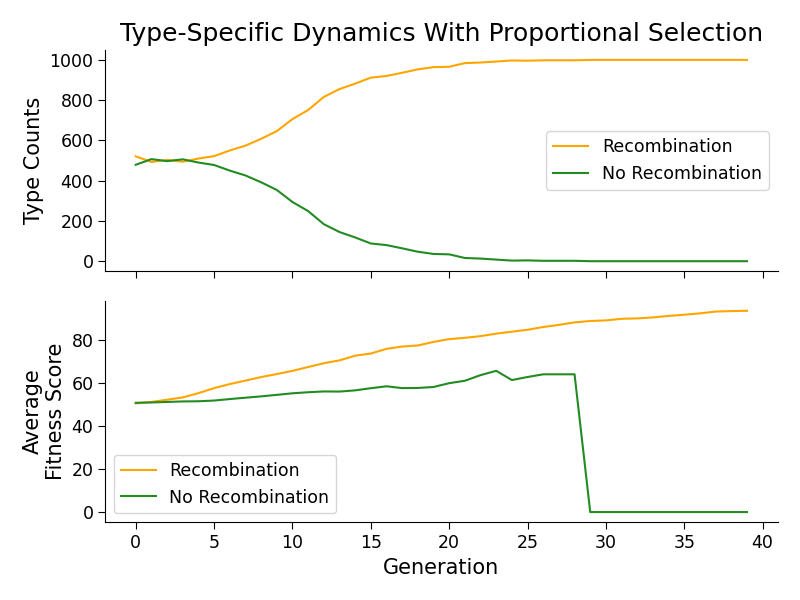

In [12]:
# @markdown **Run this cell** to see a sub-population with recombination outcompete a sub-population without.
recomb_v_no_var_params = {
    'n_gen': 40,
    'pop_size': 1000,
    'seed': 123,
    'mutation_rate': 0.005,
    'has_mutation': False,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'has_distinct_types': True,
    'truncation_threshold': 0.5,
    'init_pop': 'simple',
    'selection_type': 'proportional'
}

results = selection_variation_type_simulation(**recomb_v_no_var_params)

type_colors = {
    'mutator_non_recombinator': 'dodgerblue',
    'recombinator_non_mutator': 'orange',
    'neither': 'forestgreen',
    'both': 'crimson'
}

plot_labels = {
  'neither': 'No Recombination',
  'both': 'Recombination + Mutation',
  'recombinator_non_mutator': 'Recombination',
  'mutator': 'Mutation'}

def plot_type_results(ax, type_hist, label, color):
  generations = np.arange(len(type_hist))
  ax.plot(generations, type_hist, color=color, label=label)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax1, ax2 = ax

if 'type_count_hist' in results:
  for type_label, type_hist in results['type_count_hist'].items():
    color = type_colors.get(type_label, 'gray')  # Default to gray if type not found
    plot_type_results(ax1, type_hist, label=plot_labels[type_label], color=color)
  for type_label, type_hist in results['type_mean_fitness_hist'].items():
    color = type_colors.get(type_label, 'gray')
    plot_type_results(ax2, type_hist, label=plot_labels[type_label], color=color)

ax2.set_xlabel('Generation')
ax1.set_ylabel('Type Counts')
ax2.set_ylabel('Average\nFitness Score')
ax1.set_title('Type-Specific Dynamics With Proportional Selection')
ax1.legend()
ax2.legend()
plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

Now if both sub-populations are already well suited to the environment, recombination doesn't confer any particular advantage at all, as we can see in this simulation here.

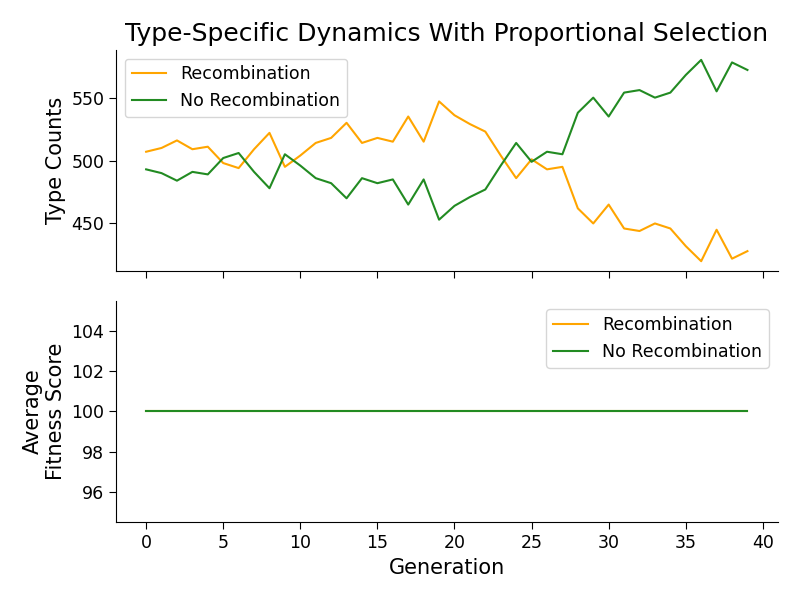

In [13]:
# @markdown **Run this cell** to see how recombination is selectively neutral if the population is already adapted to the environment.
recomb_v_no_var_params = {
    'n_gen': 40,
    'pop_size': 1000,
    'seed': 123,
    'mutation_rate': 0.005,
    'has_mutation': False,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'has_distinct_types': True,
    'truncation_threshold': 0.5,
    'init_pop': 'adapted',
    'selection_type': 'proportional'
}

results = selection_variation_type_simulation(**recomb_v_no_var_params)

type_colors = {
    'mutator_non_recombinator': 'dodgerblue',
    'recombinator_non_mutator': 'orange',
    'neither': 'forestgreen',
    'both': 'crimson'
}

plot_labels = {
  'neither': 'No Recombination',
  'both': 'Recombination + Mutation',
  'recombinator_non_mutator': 'Recombination',
  'mutator': 'Mutation'}

def plot_type_results(ax, type_hist, label, color):
  generations = np.arange(len(type_hist))
  ax.plot(generations, type_hist, color=color, label=label)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax1, ax2 = ax

if 'type_count_hist' in results:
  for type_label, type_hist in results['type_count_hist'].items():
    color = type_colors.get(type_label, 'gray')  # Default to gray if type not found
    plot_type_results(ax1, type_hist, label=plot_labels[type_label], color=color)
  for type_label, type_hist in results['type_mean_fitness_hist'].items():
    color = type_colors.get(type_label, 'gray')
    plot_type_results(ax2, type_hist, label=plot_labels[type_label], color=color)

ax2.set_xlabel('Generation')
ax1.set_ylabel('Type Counts')
ax2.set_ylabel('Average\nFitness Score')
ax1.set_title('Type-Specific Dynamics With Proportional Selection')
ax1.legend()
ax2.legend()
plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

While recombination provides significant advantages in terms of adaptability and genetic diversity, sexual reproduction is a logistical challenge with inherent costs. These costs might include the energy and time expended in finding and attracting a suitable mate, the resources required for producing and maintaining gametes, and the risks involved in mating behaviors. In some species, these costs are substantial, leading to complex mating rituals, territorial disputes, and significant energy investment in reproductive structures.

How important is rapid adaptation relative to these costs? How often do populations need to adapt to new and challenging environments that previous generations may never have encountered? In the next sequence we will look at how evolutionary process are not just responsive to abiotic sources of environmental variability, e.g. celestial mechanics, weather, geology etc., evolutionary processes are also key drivers of environmental variability; evolution itself creates environments of constant flux.

For now though we conclude with a quiz on the prevalence and diversity of sex and recombination in the natural world. What does the ubiquity of sex suggest about the importance of rapid adaptivity for life on earth?

In [14]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M6")

# Quiz: Who Has Sex?

In [15]:
# @markdown **Run this cell** to take the quiz.
reproductive_strategies_quiz = [
  {
    "question": "Bacteria have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Bacteria engage in horizontal gene transfer, often via plasmids. For example, in Escherichia coli, this genetic exchange occurs during conjugation where a donor cell passes DNA to a recipient through a pilus."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, bacteria do engage in a form of genetic exchange known as horizontal gene transfer, which is a critical mechanism for acquiring new traits."
      }
    ]
  },
  {
    "question": "Yeast have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Saccharomyces cerevisiae switches between 'a' and 'alpha' mating types. The sexual cycle involves cells of opposite types fusing to form a diploid zygote, which can then undergo meiosis to generate genetic diversity."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "In reality, yeast like Saccharomyces cerevisiae can switch mating types and engage in sexual reproduction, contributing to genetic diversity."
      }
    ]
  },
  {
    "question": "Flowering trees, grass, and other plants have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! In angiosperms (flowering plants), sexual reproduction involves pollen (male gamete) from the stamen fertilizing the ovule (female gamete) in the ovary. This genetic exchange results in seed formation."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, flowering plants do engage in sexual reproduction, with pollen from the male part fertilizing the female ovule."
      }
    ]
  },
  {
    "question": "Non-flowering plants like conifers and ferns have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Gymnosperms like pines use cones for reproduction. Pollen from male cones fertilizes ovules in female cones. Ferns, reproducing via spores, have a gametophyte stage where sperm fertilizes eggs, leading to a new sporophyte generation."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Contrary to this option, non-flowering plants like gymnosperms and ferns do have sex. Gymnosperms use cones, and ferns use spores and gametophytes for sexual reproduction."
      }
    ]
  },
  {
    "question": "Mushrooms have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! In fungi like mushrooms, sexual reproduction involves the fusion of compatible hyphae, leading to genetic exchange and eventually the formation of a fruiting body where spores are produced."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, mushrooms and other fungi do engage in sexual reproduction through the fusion of compatible hyphae."
      }
    ]
  },
  {
    "question": "Lichens have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! In lichens, the fungal partner can reproduce sexually, producing spores. These spores need to meet compatible algae to form new lichens, enabling genetic exchange."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "In fact, lichens do engage in sexual reproduction via the fungal partner, which produces spores that combine with compatible algae."
      }
    ]
  },
  {
    "question": "Mosses have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Mosses have a gametophyte stage, where sexual reproduction occurs with the production of gametes, and a sporophyte stage, where spores are formed. The fusion of gametes results in genetic exchange."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Contrary to this choice, mosses do have a sexual reproduction phase in their gametophyte stage, where gametes fuse and exchange genetic material."
      }
    ]
  },
  {
    "question": "Green algae have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Many green algae, like Chlamydomonas, have two mating types and reproduce sexually by fusing their gametes. Some species can even switch their mating type."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, green algae, including species like Chlamydomonas, do engage in sexual reproduction and can have distinct mating types."
      }
    ]
  },
  {
    "question": "Animals have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes, in incredibly diverse ways! This includes internal fertilization in mammals, external fertilization in many fish and amphibians, hermaphroditism in earthworms, and sequential hermaphroditism in clownfish."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, animals have a wide range of sexual reproduction strategies, from internal fertilization to hermaphroditism."
      }
    ]
  },
  {
    "question": "Everything always uses sex for reproduction.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": False,
        "feedback": "This statement is not entirely accurate. While sexual reproduction is widespread, many organisms like certain plants and animals also reproduce asexually, especially under certain environmental conditions."
      },
      {
        "answer": "False",
        "correct": True,
        "feedback": "No not always, but almost everything does at some point. While many organisms predominantly clone themselves, such as aphids and some plants like strawberries, they often resort to sexual reproduction, especially under stress. Species without any genetic exchange are extremely rare and often face challenges in long-term survival due to the lack of genetic diversity."
      }
    ]
  }
]

display_quiz(reproductive_strategies_quiz)

<IPython.core.display.Javascript object>

# Glossary

**Math Notation**
1. **Mean** ($\mu$): The expected value of a probability distribution. The formula is:
   $$
   \mu = \mathbb{E}[X] = \int_{-\infty}^{\infty} x f(x) \, dx
   $$
   where $X$ is a random variable and $f(x)$ is the probability density function of $X$. The average of many samples from a distribution converges to the mean of the distribution.

2. **Variance** ($\sigma^2$): A measure of the spread or dispersion of a probability distribution. The formula is:
   $$
   \sigma^2 = \mathbb{E}[(X - \mu)^2] = \int_{-\infty}^{\infty} (x - \mu)^2 f(x) \, dx
   $$
   where $X$ is a random variable, $\mu$ is the mean of $X$, and $f(x)$ is the probability density function of $X$.

3. Standard Deviation ($\sigma$): The square root of the variance, representing the average amount by which each number in a set differs from the mean. Unlike variance, standard deviation has the same units and dimension as the mean.

4. Skew ($\gamma$): A measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Positive skew indicates a distribution with an asymmetric tail extending towards more positive values.

5. Binomial Distribution: A probability distribution that models the number of 'successes' over a fixed number of trials, given each trial is independent and has the same probability of success, e.g. number of heads in a series of 10 coin flips. Typically denoted and parameterized as $\text{Bin}\left(n, p\right)$ where $n$ is the number of trials and $p$ is the probability of success.
    
6. Normal Distribution: A probability distribution that is symmetric around the mean, with values closer to the mean being more frequent/likely than those far from the mean. Typically denoted as $\mathcal{N}(\mu, \sigma^2)$ and parameterized in terms of mean and variance. Normal distributions are good models for random variables that are the sum of many other random variables (as a result of the central limit theorem). Note that the average of independent observations is the sum of many random variabbles, and so sample mean (for large enough sample size) is well approximated by a normal distribution.

7. Multinomial Distribution: A generalization of the binomial distribution. It models the probability of counts of each side of a multi-sided die (not a coin) rolled a fixed number of times.

**Model Variables and Notation**

1. Genotype ($g$): The genetic constitution of an individual organism, represented as bit-string of alleles in our simulations. $g_i$ denotes the $i^th$ bit in the bit-string.

2. Genotye length ($n$): In our analyses $n$ denotes the number of bits in the genotype.

3. Fitness Score ($z(g)$): A numerical representation of an organism's reproductive success or suitability to the environment. In our models this is calculated as the sum of the 'good' alleles (represented as 1s) in the genotype. $z(g):= \sum_{i=1}^n g_i$.

4. $\beta$: A scale factor used in our models to rewrite the variance of the parent population in terms of the variance introduced by mutation or recombination.

5. $t$: A time index, measured in discrete non-overlapping generations in our evolutionary.

6. $\delta$: A term used to represent the 'excess fitness score', calculated as $\delta := z - \frac{n}{2}$, used to simplify some of the analyses in our mathematical models.

7. $m$: Mutation Rate, the probability of any given bit (allele) in a genotype mutating in one generation.


**Biology Terms**
1. Fitness (Growth Rate): The rate of growth of a given type or class in a population. In models this is often determined by fitness score interacting with the specific selection process of the model.

2. Recombination: A process by which genetic material is rearranged during sexual reproduction, leading to offspring with combinations of traits that differ from those in the parents.

3. Assortative Mating: A mating pattern where individuals with certain genotypes or phenotypes tend to mate with one another more frequently than would be expected under a random mating pattern.
    
    